# BikeSafePA: Analyzing cyclist-involved crashes in Pennsylvania, 2002-2021

## Part III: Building the BikeSafePA predictive model

In this part we will construct BikeSafePA, a model designed to predict whether or not a cyclist suffered serious injury or fatality.  We begin by importing necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',None)

import scipy.stats as ss
import shap

from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, f1_score, fbeta_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV, StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer, SplineTransformer, PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

### Navigation:

* [Data and features](#data)
    * [Feature descriptions](#features)
    * [Missing data](#missing)
    * [Preparing dataframes](#dataframes)
* [Helper functions and classes](#functions)
    * [Groupwise imputer class](#group)
    * [Transformations for periodic features](#periodic)
    * [Main ClassifierStudy class](#class)
* [Metrics for scoring](#metrics)
* [Logistic Regression models](#logistic)
    * [Feature selection using model coefficients](#logistic_coeff)
    * [Baseline cross-validation scores](#logistic_cv)
    * [Tuning hyperparameters](#logistic_tuning)
    * [Choosing classification threshold](#logistic_threshold)
* [Gradient Boosted Decision Tree models](#tree)
    * [Baseline cross-validation scores](#tree_cv)
    * [Tuning hyperparameters](#tree_tuning)
    * [Choosing classification threshold](#tree_threshold)
* [Selecting our BikeSafePA model](#select)
* [Evaluating models on the hold-out test set](#eval)
    * [Logistic Regression scores](#eval_logistic)
    * [Gradient Boosted Decision Tree scores](#eval_tree)
* [Explaining BikeSafePA's decisions via SHAP values](#shap)
    * [SHAP plots for BikeSafePA](#shap_plots)
    * [Discussion of features importance from SHAP](#shap_fi)
* [Summary of process and results](#summary)
* [Reflections on model performance](#model_reflections)
* [Conclusions based on SHAP values](#shap_conclusions)
* [Policy recommendations based on BikeSafePA](#recommendations)
    

<a id="data"></a>
### Data and features
Let's read in our dataset and create some additional binary features that we'll use in our models.

In [2]:
cyclists = pd.read_csv('cyclists.csv')

In [3]:
# Define a binary feature HILL to replace GRADE
cyclists['HILL'] = cyclists.GRADE.isin(['downhill','uphill','bottom_hill','top_hill']).astype(int)

# We'll compute groupwise mode (with dropna = False) to impute missing SEX data in our pipeline.
# Mode can't compare 'F' or 'M' with np.nan which can cause issues when multiple modes exist
# Note that among floats, 0 < 1 < np.nan
cyclists['FEMALE'] = cyclists['SEX'].replace({'F':1,'M':0})

<a id="features"></a>
#### Feature descriptions

We'll start with the following model features:

* Input features:
    * Categorical features: these we'll encode as one-hot vectors in our pipeline.  We list their respective categories here:
        * RESTRAINT_HELMET - ['no_restraint' 'unknown' 'bicycle_helmet' 'motorcycle_helmet','helmet_improper']
        * URBAN_RURAL - ['urban' 'urbanized' 'rural']
        * ILLUMINATION - ['daylight' 'dark_lit' 'dusk' 'dark_unlit' 'dawn' 'other']
        * ROAD_CONDITION - ['dry' 'wet' 'other' 'slush' 'snow' 'water' 'ice_frost' nan]
 'mud_dirt_gravel']
        * VEH_ROLE - ['struck' 'striking' 'non_collision' 'striking_struck']
        * WEATHER - ['clear' 'rain' 'snow' 'sleet_hail' nan 'fog_smog_smoke' 'other'
 'blowing_snow' 'cloudy' 'freezing_rain']
        * COLLISION_TYPE - ['sideswipe_same_dir' 'angle' 'other' 'head_on' 'hit_ped' 'non_collision'
 'rear_end' 'sideswipe_opp_dir' 'backing' 'hit_fixed_obj' nan]
        * IMPACT_SIDE - ['left' 'front' 'unknown' 'right' 'rear' 'non_collision' 'top'
 'undercarriage']
        * TCD_TYPE - ['not_applicable' 'stop_sign' 'traffic_signal' nan
 'flashing_traffic_signal' 'yield_sign' 'other' 'passive_RR_controls'
 'officer_or_flagman' 'active_RR_controls']
        * TCD_FUNC_CD - ['no_controls' 'functioning_properly' nan 'functioning_improperly'
 'not_functioning' 'emergency_preemptive_signal']
    * Numerical features: AGE, SPEED_LIMIT, CRASH_YEAR
    * Ordinal features: BUS_COUNT, COMM_VEH_COUNT, HEAVY_TRUCK_COUNT, SMALL_TRUCK_COUNT, SUV_COUNT, VAN_COUNT (note: these are *almost* binary - they take values 0, 1, 2 and very few samples have one of these features equal to 2)
    * Binary features: None of these have missing values except FEMALE. Some of these are self-explanatory, but for others we clarify here what they indicate.
        * FEMALE - the cyclist was reported as female.  Has missing values inherited from missing values in SEX
        * HILL - the cyclist was traveling uphill or downhill, or was at the top or the bottom of a hill
        * NON_INTERSECTION - the crash occured mid-block
        * CURVED_ROAD - the crash occured on a curved section of roadway
        * Driver (at least one driver in the crash met the condition or behavior criteria): ALCOHOL_RELATED,CURVE_DVR_ERROR, DRINKING_DRIVER, DRUGGED_DRIVER, DRUG_RELATED, FATIGUE_ASLEEP, DISTRACTED, AGGRESSIVE_DRIVING, CELL_PHONE, LANE_DEPARTURE, NO_CLEARANCE,NHTSA_AGG_DRIVING, CROSS_MEDIAN, RUNNING_RED_LT, RUNNING_STOP_SIGN, TAILGATING, MATURE_DRIVER, YOUNG_DRIVER, SPEEDING_RELATED
            * Note that AGGRESSIVE_DRIVING requires a driver to take at least one action classified as aggressive driving. NHTSA_AGG_DRIVING requires a driver to take at least two different such actions.
            * Note that DRUGGED_DRIVER and DRINKING_DRIVER refer specifically to motor vehicle drivers, while all other condition/behavior flags can be referring to any kind of driver including cyclists.
        * Other flags: SUDDEN_DEER, WORK_ZONE
        
    * Target feature: SERIOUS_OR_FATALITY - a binary feature.  This is what we want to predict.
        * 1 means the cyclist is known to have suffered a serious injury or fatality as a result of the crash
        * 0 means the cyclist did not (perhaps they suffered a minor injury, no injury, or have unknown injury status)
        
Throughout this notebook we'll use several different feature sets. Let's store them in a single dictionary.  The first key:value pair will correspond to this full feature set.

In [4]:
# Feature subsets
feat_dict = {}
feat_dict['all'] = {'cyc':['DAY_OF_WEEK','HOUR_OF_DAY'],
                    'ord':['BUS_COUNT','HEAVY_TRUCK_COUNT','COMM_VEH_COUNT',
                           'SMALL_TRUCK_COUNT','SUV_COUNT','VAN_COUNT'],
                    'cat':['RESTRAINT_HELMET','VEH_ROLE',
                           'URBAN_RURAL','ILLUMINATION',
                           'ROAD_CONDITION','WEATHER',
                           'COLLISION_TYPE','IMPACT_SIDE',
                           'TCD_TYPE','TCD_FUNC_CD'],
                    'group':['MUNICIPALITY','COUNTY','CRASH_MONTH'],
                    'num':['AGE','SPEED_LIMIT','CRASH_YEAR'],
                    'bin':['FEMALE','HILL','NON_INTERSECTION','CURVED_ROAD',
                           'ALCOHOL_RELATED','CURVE_DVR_ERROR',
                          'DRINKING_DRIVER','DRUGGED_DRIVER','DRUG_RELATED',
                          'DISTRACTED','FATIGUE_ASLEEP',
                          'AGGRESSIVE_DRIVING','CELL_PHONE','LANE_DEPARTURE',
                          'NO_CLEARANCE','NHTSA_AGG_DRIVING','CROSS_MEDIAN',
                          'RUNNING_RED_LT','RUNNING_STOP_SIGN','TAILGATING',
                          'SPEEDING_RELATED',
                          'MATURE_DRIVER','YOUNG_DRIVER',
                          'SUDDEN_DEER','WORK_ZONE']
                     }
TARGET = 'SERIOUS_OR_FATALITY'

<a id="missing"></a>
#### Missing values
A few of the above features have missing values, which we will impute via our machine learning pipeline:
* We will impute missing AGE and HOUR_OF_DAY values using a groupwise aggregation, which will require us to define a custom imputating class:
    * Impute AGE via grouping by COUNTY and aggregating via median (we considered using median by MUNICIPALITY, but 475 out of the 1578 municipalities only have one sample each)
    * Impute HOUR_OF_DAY via grouping by (ILLUMINATION, CRASH_MONTH) and aggregating via mode.
* We will impute all others via global mode (using SimpleImputer)

<a id="dataframe"></a>
#### Dataframe preparation
We separate features into several categories so that our pipeline function handles them properly.  Note that the features in GROUP_FEATURES will be used in our missing data imputation process but won't be used as model features.  Also, we'll do a train_test_split to take off a holdout set (X_test,y_test) which we won't touch again until evaluating our final models at the end of our study.

In [5]:
df = cyclists[[feat for feat_type in feat_dict['all'] for feat in feat_dict['all'][feat_type]]+[TARGET]]
X = df.drop(TARGET,axis=1)
y= df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

<a id="functions"></a>
### Helper functions and classes

<a id="group"></a>
#### Groupwise imputer class
This pipeline step will allow us to fill missing data using a groupwise aggregated mean, median, or mode.

In [6]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """
    Class used for imputing missing values in a pd.DataFrame
    using mean, median, or mode by groupwise aggregation,
    or a constant.
    
    Parameters:
    -----------
    target : str 
        - The name of the column to be imputed
    group_cols : list
        - List of name(s) of columns on which to groupby
    strategy : str
         - The method for replacement; can be any of
          ['mean', 'median', 'mode']
    
    Returns:
    --------
    X : pd.DataFrame
        - The dataframe with imputed values in the target column
    
    """
    def __init__(self,target,group_cols=None,strategy='median'):
        assert strategy in ['mean','median','mode'], "strategy must be in ['mean', 'median', 'mode']'"
        assert type(group_cols)==list, 'group_cols must be a list of column names'
        assert type(target) == str, 'target must be a string'
        
        self.group_cols = group_cols
        self.strategy=strategy
        self.target = target
        
    def fit(self,X,y=None):
        
        if self.strategy=='mode':
            impute_map = X.groupby(self.group_cols)[self.target]\
                            .agg(lambda x: pd.Series.mode(x,dropna=False)[0])\
                            .reset_index(drop=False)
        else:
            impute_map = X.groupby(self.group_cols)[self.target]\
                        .agg(self.strategy).reset_index(drop=False)
        self.impute_map_ = impute_map
        
        return self
        
    def transform(self,X,y=None):
        
        check_is_fitted(self,'impute_map_')
        
        X=X.copy()
        
        for index,row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind,self.target] = X.loc[ind,self.target].fillna(row[self.target])
        return X
    


<a id="periodic"></a>
#### Transformations for periodic features
Periodic encoding can be important for features that are cyclic in nature, so that the model can learn the relationship between the highest and lowest values (e.g. hour 0 is close to hour 23, chronologically).  We examine several options for transforming the periodic features DAY_OF_WEEK and HOUR_OF_DAY:  
* Using one-hot encoding
* Using ordinal encoding
* Using sine and cosine transformations.  This pair effectively maps the feature onto the unit circle in the plane.  This produces fewest features, while encoding cyclic relationships - e.g. hour 23 is close to hour 0.
* Using periodic splines, where we can adjust the parameter n_splines.  We will end up setting n_splines to roughly half of the range of the feature, i.e. n_splines = 12 for HOUR_OF_DAY and n_splines = 7 for DAY_OF_WEEK.  Note that this results in fewer features than one-hot-encoding, while allowing our model to be more expressive than sine and cosine encoding.
* Using a hybrid method which attempts to capture the interaction between HOUR_OF_DAY and whether the day is on a weekend or not:
    * spline or trig encoding for HOUR_OF_DAY
    * binary encoding for whether DAY_OF_WEEK is on a weekend or not
    * follow up with polynomial features that include interaction terms

In [7]:
# Sine and consine transformations
def sin_feature_names(transformer, feature_names):
    return [f'SIN_{col}' for col in feature_names]
def cos_feature_names(transformer, feature_names):
    return [f'COS_{col}' for col in feature_names]    
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(2*np.pi*x/period),feature_names_out = sin_feature_names)
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(2*np.pi*x/period),feature_names_out = cos_feature_names)

# Periodic spline transformation
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

<a id="class"></a>
#### Custom class for constructing, fitting, and evaluating classifier pipelines
The analysis that follows will be made easier if we design a custom class which can:
* Build the model pipeline
* Fit the model pipeline
* Score a fitted model pipeline
* Run k-fold (repeated) cross validation, to evaluate models
* Run randomized search with cross validation, to tune hyperparameters
* Compute and plot SHAP (SHapley Additive exPlanation) values for features

In [11]:
class ClassifierStudy():
    """
    A class that contains tools for studying a classifier pipeline
    
    Parameters:
    -----------
    classifier : a scikit-learn compatible binary classifier
    X : pd.DataFrame
        dataframe of features
    y : pd.Series
        series of binary target values corresponding to X
    classifier_name : str or None
        if provided, will use as classifier name in pipeline
        if not, will use 'clf' as name
    features : dict
        a dictionary whose keys are the feature types
        'cyc','cat','ord','num','bin' and whose values
        are lists of features of each type.
        
    Methods:
    -------
    set_data, set_features, set_state
        sets or resets attributes of self
    build_pipeline
        builds out pipeline based on supplied specs
    cv_score
        runs k-fold cross validation and reports scores
    randomized_search
        runs randomized search with cross validation
        and reports results
    fit_pipeline
        fits the model pipeline and stores as
        self.pipe_fitted
    predict_proba_pipeline
        uses a fitted pipeline to compute predicted
        probabilities for test or validation set
    score_pipeline
        scores predicted probabilities
        
    """
    def __init__(self, classifier=None, X = None, y = None,
                 features = feat_dict['all'],classifier_name = None,
                 random_state=42):
        self.classifier = classifier
        if X is not None:
            self.X = X.copy()
        if y is not None:
            self.y = y.copy()
        if features is not None:
            self.features = features.copy()
        self.random_state=random_state
        self.pipe, self.pipe_fitted = None, None
        self.classifier_name = classifier_name
        self.X_val, self.y_val = None, None
        self.y_predica_proba = None
        self.best_params, self.best_n_components = None, None
        self.shap_vals = None
    
    def set_data(self,X=None,y=None):
        """Method to set or reset feature and/or target data"""
        if X is not None:
            self.X = X.copy()
        if y is not None:
            self.y = y.copy()
    
    def set_features(self,features):
        """Method to set or reset the feature dictionary"""
        if features is not None:
            self.features = features.copy()        
    
    def set_state(self,random_state):
        """Method to set or reset the random_state"""
        self.random_state = random_state
        
    def build_pipeline(self, cat_method = 'onehot',cyc_method = 'spline',num_ss=True,
                       over_sample = False, pca=False,n_components=None,
                       select_features = False,score_func=f_classif,k='all',
                       poly_features = False, degree=2, interaction_only=False):
        """
        Method to build the model pipeline
        Parameters:
        -----------
        cat_method : str
            specifies whether to encode categorical
            variables as one-hot vectors or ordinals
            must be either 'onehot' or 'ord'
        cyc_method : str
            specifies whether to encode cyclical features
            with sine/cosine encoding or periodic splines
            must be one of 'trig', 'spline', 'interact-trig',
            'interact-spline','onehot', 'ord', or None
            - If 'trig' or 'spline', will set up periodic encoder
              with desired method
            - If 'onehot' or 'ord', will set up appropriate
              categorical encoder
            - If 'interact-{method}', will use <method> encoding for HOUR_OF_DAY,
              encode DAY_OF_WEEK as a binary feature expressing whether
              the day is a weekend day, and then include interaction
              features among this set via PolynomialFeatures.
            - If None, will leave out cyclical features altogether
        num_ss : bool
            Whether or not to apply StandardScaler on the numerical features
        over_sample : bool
            set to True to include imblearn.over_sampling.RandomOverSampler step
        pca : bool
            set to True to include sklearn.decomposition.PCA step
        n_components : int or None
            number of components for sklearn.decomposition.PCA
        select_features : bool
            set to True to include sklearn.feature_selection.SelectKBest step
        score_func : callable
            score function to use for sklearn.feature_selection.SelectKBest
            recommended: chi2, f_classif, or mutual_info_classif
        k : int or 'all'
            number of features for sklearn.feature_selection.SelectKBest
        poly_features : bool
            set to True to include sklearn.preprocessing.PolynomialFeatures step
        degree : int
            max degree for sklearn.preprocessing.PolynomialFeatures
        interaction_only : bool
            whether or not sklearn.preprocessing.PolynomialFeatures will be limited
            to interaction terms only
        """
        
        # Define transformer for categorical features
        if cat_method == 'onehot':
            cat_encoder = ('ohe',OneHotEncoder(handle_unknown='infrequent_if_exist'))
                                
        elif cat_method == 'ord':
            cat_encoder = ('oe',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan))
        else:
            raise ValueError("cat_method must be either 'onehot' or 'ord'")
    
        cat_transform = Pipeline([('si',SimpleImputer(strategy='most_frequent')),cat_encoder])
    
        # Define transformer for cyclic features
        cyc_dict = {'HOUR_OF_DAY':24,'DAY_OF_WEEK':7}
        if cyc_method == 'trig':
            cyc_transform = [(f'{feat}_cos',cos_transformer(cyc_dict[feat]),[feat]) for feat in self.features['cyc']]+\
                        [(f'{feat}_sin',sin_transformer(cyc_dict[feat]),[feat]) for feat in self.features['cyc']]
        elif cyc_method =='spline':
            cyc_transform = [(f'{feat}_cyclic',
                          periodic_spline_transformer(cyc_dict[feat],n_splines=cyc_dict[feat]//2),
                          [feat]) for feat in self.features['cyc']]
        elif cyc_method == 'onehot':
            cyc_encoder = ('ohe_cyc',OneHotEncoder(handle_unknown='infrequent_if_exist'))
            cyc_transform = [('cyc',Pipeline([cyc_encoder]),self.features['cyc'])]
        elif cyc_method == 'ord':
            cyc_encoder = ('oe_cyc',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan))
            cyc_transform = [('cyc',Pipeline([cyc_encoder]),self.features['cyc'])]
        elif cyc_method == 'interact-spline':
            hour_transform = (f'hour_cyc',periodic_spline_transformer(cyc_dict['HOUR_OF_DAY'],n_splines=12),['HOUR_OF_DAY'])
            wkend_transform = ('wkend',FunctionTransformer(lambda x: (x.isin([1,7])).astype(int)),['DAY_OF_WEEK'])
            cyc_transform = [('cyc',Pipeline([('cyc_col',ColumnTransformer([hour_transform, wkend_transform],
                                                               remainder='drop',verbose_feature_names_out=False)),
                                              ('cyc_poly',PolynomialFeatures(degree=2,interaction_only=True,
                                                                include_bias=False))]),
                             self.features['cyc'])]
        elif cyc_method == 'interact-trig':
            hour_transform = [(f'HOUR_cos',cos_transformer(cyc_dict['HOUR_OF_DAY']),['HOUR_OF_DAY']),
                              (f'HOUR_sin',sin_transformer(cyc_dict['HOUR_OF_DAY']),['HOUR_OF_DAY'])]
            wkend_transform = ('wkend',FunctionTransformer(lambda x: (x.isin([1,7])).astype(int)),['DAY_OF_WEEK'])
            cyc_transform = [('cyc',Pipeline([('cyc_col',ColumnTransformer(hour_transform+[wkend_transform],
                                                               remainder='drop',verbose_feature_names_out=False)),
                                              ('cyc_poly',PolynomialFeatures(degree=2,interaction_only=True,
                                                                include_bias=False))]),
                             self.features['cyc'])]
        elif cyc_method is None:
            cyc_transform = [('cyc','passthrough',[])]
        else:
            raise ValueError("cyc_method must be one of 'trig','spline','interact','onehot','ord',or None")
        
        # Define numerical transform
        num_transform = ('num',StandardScaler(),self.features['num']) if num_ss else\
                        ('num','passthrough',self.features['num'])
        
        # Define column transformer
        col_transform = ColumnTransformer([('cat',cat_transform,self.features['cat']),
                                           ('ord','passthrough',self.features['ord']),
                                           num_transform,
                                           ('bin',SimpleImputer(strategy='most_frequent'),
                                             self.features['bin'])]+\
                                           cyc_transform,
                                           remainder='drop',verbose_feature_names_out=False)
    
        steps = [('col',col_transform)]
    
        if 'AGE' in self.features['num']:
            steps.insert(0,('gi_age',GroupImputer(target = 'AGE', group_cols=['COUNTY'],strategy='median')))
        if 'HOUR_OF_DAY' in self.features['cyc']:
            steps.insert(0,('gi_hour',GroupImputer(target = 'HOUR_OF_DAY', group_cols=['ILLUMINATION','CRASH_MONTH'],strategy='mode')))
        # Insert optional steps as needed
        if over_sample:
            steps.insert(0,('os',RandomOverSampler(random_state=self.random_state)))
        if poly_features:
            steps.append(('pf',PolynomialFeatures(degree=degree,interaction_only=interaction_only)))
        if select_features:
            steps.append(('fs',SelectKBest(score_func = score_func, k = k)))
        if pca:
            steps.append(('pca',PCA(n_components=n_components,random_state=self.random_state)))
        # Append classifier if provided
        if self.classifier is not None:
            if self.classifier_name is not None:
                steps.append((f'{self.classifier_name}_clf',self.classifier))
            else:
                steps.append(('clf',self.classifier))
    
        # Initialize pipeline
        self.pipe = Pipeline(steps)
    
    def cv_score(self, scoring = 'roc_auc', n_splits = 5, n_repeats=3, thresh = 0.5, beta = 1,
                 return_mean_score=False,print_mean_score=True,print_scores=False, n_jobs=-1):
        """
        Method for performing cross validation via RepeatedStratifiedKFold
        
        Parameters:
        -----------
        scoring : str
            scoring function to use.  must be one of
            'roc_auc','acc','f1','','f1w'
        thresh : float
            the classification threshold for computing y_pred
            from y_pred_proba
        beta : float
            the beta-value to use in the f_beta score, if chosen
        n_splits, n_repeats : int, int
            number of splits and number of repeat iterations
            for sklearn.model_selection.RepeatedStratifiedKFold
        return_mean_score : bool
            whether or not to return the mean score
        print_mean_score : bool
            whether to print out a report of the mean score
        print_scores : bool
            whether to print out a report of CV scores for all folds
        n_jobs : int or None
            number of CPU cores to use for parallel processing
            -1 uses all available cores, and None defaults to 1
        Returns: None or mean_score, depending on return_mean_score setting
        --------
        """
        assert self.pipe is not None, 'No pipeline exists; first build a pipeline using build_pipeline.'
        assert (self.X is not None)&(self.y is not None), 'X and/or y does not exist.  First supply X and y using set_data.'
        assert 'clf' in self.pipe.steps[-1][0], 'The pipeline has no classifier.  Build a pipeline with a classifier first.'
        assert scoring in ['roc_auc','acc','f1','fb','f1w'],"scoring must be one of 'roc_auc','acc','f1','fb','f1w'"
        
        # Initialize CV iterator
        kf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats,
                                     random_state=self.random_state)
        # Restrict to features supplied in self.features
        X = self.X[[feat for feat_type in self.features for feat in self.features[feat_type]]]
        
        scores = []
        # Iterate over folds and train, predict, score
        for i,(train_idx,test_idx) in enumerate(kf.split(X,self.y)):
            fold_X_train = X_train.iloc[train_idx,:]
            fold_X_test = X_train.iloc[test_idx,:]
            fold_y_train = y_train.iloc[train_idx]
            fold_y_test = y_train.iloc[test_idx]
            
            pipe=clone(self.pipe)
            pipe.fit(fold_X_train,fold_y_train)
            fold_y_pred_proba = pipe.predict_proba(fold_X_test)[:,1]
            
            if scoring == 'roc_auc':
                fold_score = roc_auc_score(fold_y_test, fold_y_pred_proba)
            else:
                fold_y_pred = (fold_y_pred_proba >= thresh).astype('int')
                if scoring == 'acc':
                    fold_score = accuracy_score(fold_y_test,fold_y_pred)
                elif scoring == 'f1':
                    fold_score = f1_score(fold_y_test,fold_y_pred)
                elif scoring == 'f1w':
                    fold_score = f1_score(fold_y_test,fold_y_pred,average='weighted')
                else:
                    fold_score = fbeta_score(fold_y_test,fold_y_pred,beta=beta)
            scores.append(fold_score)
        
        # Average and report
        mean_score = np.mean(scores)
        if print_scores:
            print(f'CV scores using {scoring} score: {scores} \nMean score: {mean_score}')
        if print_mean_score:
            print(f'Mean CV {scoring} score: {mean_score}')
        if return_mean_score:
            return mean_score
            
    def randomized_search(self, params, n_components = None, n_iter=10,scoring='roc_auc',cv=5,refit=False,top_n=10, n_jobs=-1):
        """
        Method for performing randomized search with cross validation on a given dictionary of parameter distributions
        Also displays a table of results the best top_n iterations
        
        Parameters:
        ----------
        params : dict
            parameter distributions to use for RandomizedSearchCV
        n_components : int, or list, or None
            number of components for sklearn.decomposition.PCA
            - if int, will reset the PCA layer in self.pipe with provided value
            - if list, must be list of ints, which will be included in
              RandomizedSearchCV parameter distribution
        scoring : str
            scoring function for sklearn.model_selection.cross_val_score
        n_iter : int
            number of iterations to use in RandomizedSearchCV
        refit : bool
            whether to refit a final classifier with best parameters
            - if False, will only set self.best_params and self.best_score
            - if True, will set self.best_estimator in addition
        top_n : int or None
            if int, will display results from top_n best iterations only
            if None, will display all results
        n_jobs : int or None
            number of CPU cores to use for parallel processing
            -1 uses all available cores, and None defaults to 1
        """
        assert self.pipe is not None, 'No pipeline exists; first build a pipeline using build_pipeline.'
        assert (self.X is not None)&(self.y is not None), 'X and/or y does not exist.  First supply X and y using set_data.'
        assert 'clf' in self.pipe.steps[-1][0], 'The pipeline has no classifier.  Build a pipeline with a classifier first.'
        assert (n_components is None)|('pca' in self.pipe.named_steps), 'Your pipeline has no PCA step.  Build a pipeline with PCA first.'
        assert (len(params)>0)|(type(n_components)==list), 'Either pass a parameter distribution or a list of n_components values.'
        
        # Add estimator name prefix to hyperparams
        params = {self.pipe.steps[-1][0]+'__'+key:params[key] for key in params}
        
        # Process supplied n_components
        if type(n_components)==list:
            params['pca__n_components']=n_components
        elif type(n_components)==int:
            self.pipe['pca'].set_params(n_components=n_components)
        
        # Restrict to features supplied in self.features
        X = self.X[[feat for feat_type in self.features for feat in self.features[feat_type]]]
    
        # Initialize CV and fit
        rs = RandomizedSearchCV(self.pipe, param_distributions = params,
                                n_iter=n_iter, scoring = scoring, cv = cv,refit=refit,
                                random_state=self.random_state, n_jobs=n_jobs)
        rs.fit(X,self.y)
    
        # Display top n scores
        results = rs.cv_results_
        results_df = pd.DataFrame(results['params'])
        param_names = list(results_df.columns)
        results_df[f'mean cv score ({scoring})']=pd.Series(results['mean_test_score'])
        results_df = results_df.set_index(param_names).sort_values(by=f'mean cv score ({scoring})',ascending=False)
        if top_n is not None:
            display(results_df.head(top_n).style\
                    .highlight_max(axis=0, props='color:white; font-weight:bold; background-color:seagreen;'))
        else:
            display(results_df.style\
                    .highlight_max(axis=0, props='color:white; font-weight:bold; background-color:seagreen;'))
        if refit:
            self.best_estimator = rs.best_estimator_
        best_params = rs.best_params_
        self.best_params = {key.split('__')[-1]:best_params[key] for key in best_params if key.split('__')[0]!='pca'}
        self.best_n_components = next((best_params[key] for key in best_params if key.split('__')[0]=='pca'), None)
        self.best_score = rs.best_score_
        
    def fit_pipeline(self,split_first=False):
        """
        Method for fitting self.pipeline on self.X,self.y
        Parameters:
        -----------
        split_first : bool
            if True, a train_test_split will be performed first
            and the validation set will be stored
        """
        # Need pipe and X to fit
        assert self.pipe is not None, 'No pipeline exists; first build a pipeline using build_pipeline.'
        assert self.X is not None, 'X does not exist.  First set X.'
        
        # If no y provided, then no pipeline steps should require y
        step_list = [step[0] for step in self.pipe.steps]
        assert (('clf' not in step_list[-1])&('kf' not in step_list))|(self.y is not None), 'You must provide targets y if pipeline has a classifier step or feature selection step.'
        
        # Don't need to do a train-test split without a classifier
        assert (split_first==False)|('clf' in step_list[-1]), 'Only need train-test split if you have a classifier.'
                
        if split_first:
            X_train,X_val,y_train,y_val = train_test_split(self.X,self.y,stratify=self.y,
                                                           test_size=0.2,random_state=self.random_state)
            self.X_val = X_val
            self.y_val = y_val
        else:
            X_train = self.X.copy()
            if self.y is not None:
                y_train = self.y.copy()        
        
        # Restrict to features supplied in self.features
        X_train = X_train[[feat for feat_type in self.features for feat in self.features[feat_type]]]
        
        # Fit and store fitted pipeline. If no classifier, fit_transform X_train and store transformed version
        pipe = self.pipe
        if 'clf' in step_list[-1]:
            pipe.fit(X_train,y_train)
        else:
            X_transformed = pipe.fit_transform(X_train)
            # X_transformed = pd.DataFrame(X_transformed,columns=pipe[-1].get_column_names_out())
            self.X_transformed = X_transformed
        self.pipe_fitted = pipe
    
    def predict_proba_pipeline(self, X_test = None):
        """
        Method for using a fitted pipeline to compute predicted
        probabilities for X_test (if supplied) or self.X_val
        Parameters:
        -----------
        X_test : pd.DataFrame or None
            test data input features (if None, will use self.X_val)
        """
        assert self.pipe is not None, 'No pipeline exists; first build a pipeline using build_pipeline.'
        assert 'clf' in self.pipe.steps[-1][0], 'The pipeline has no classifier.  Build a pipeline with a classifier first.'
        assert self.pipe_fitted is not None, 'Pipeline is not fitted.  First fit pipeline using fit_pipeline.'
        assert (X_test is not None)|(self.X_val is not None), 'Must either provide X_test and y_test or fit the pipeline with split_first=True.'
        
        if X_test is None:
            X_test = self.X_val
            
        # Restrict to features supplied in self.features
        X_test = X_test[[feat for feat_type in self.features for feat in self.features[feat_type]]]
        
        # Save prediction
        self.y_predict_proba = self.pipe_fitted.predict_proba(X_test)[:,1]
        
    def score_pipeline(self,y_test=None,scoring='roc_auc',thresh=0.5, beta = 1,
                       normalize = None, print_score = True):
        """
        Method for scoring self.pipe_fitted on supplied test data and reporting score
        Parameters:
        -----------
        y_test : pd.Series or None
            true binary targets (if None, will use self.y_val)
        scoring : str
            specifies the metric to use for scoring
            must be one of
            'roc_auc', 'roc_plot', 'acc', 'f1', 'f1w', 'fb','mcc','kappa','conf','classif_report'
        thresh : float
            threshhold value for computing y_pred
            from y_predict_proba
        beta : float
            the beta parameter in the fb score
        normalize : str or None
            the normalize parameter for the 
            confusion_matrix. must be one of
            'true','pred','all',None
        print_score : bool
            if True, will print a message reporting the score
            if False, will return the score as a float
        """
        assert (y_test is not None)|(self.y_val is not None), 'Must either provide X_test and y_test or fit the pipeline with split_first=True.'
        assert self.y_predict_proba is not None, 'Predicted probabilities do not exist.  Run predict_proba_pipeline first.'
        
        if y_test is None:
            y_test = self.y_val
        
        # Score and report
        if scoring == 'roc_plot':
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
            RocCurveDisplay.from_predictions(y_test,self.y_predict_proba,ax=ax)
            plt.show()
        elif scoring == 'roc_auc':
            score = roc_auc_score(y_test, self.y_predict_proba)
        else:
            y_pred = (self.y_predict_proba >= thresh).astype('int')
            if scoring == 'acc':
                score = accuracy_score(y_test,y_pred)
            elif scoring == 'f1':
                score = f1_score(y_test,y_pred)
            elif scoring == 'f1w':
                score = f1_score(y_test,y_pred,average='weighted')
            elif scoring == 'fb':
                score = fbeta_score(y_test,y_pred,beta=beta)
            elif scoring == 'mcc':
                score = matthews_coffcoeff(y_test,y_pred)
            elif scoring == 'kappa':
                score = cohen_kappa_score(y_test,y_pred)
            elif scoring == 'conf':
                fig = plt.figure(figsize=(3,3))
                ax = fig.add_subplot(111)
                ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=ax,colorbar=False)
                plt.show()
            elif scoring == 'classif_report':
                target_names=['neither seriously injured nor killed','seriously injured or killed']
                print(classification_report(y_test, y_pred,target_names=target_names))
            else:
                raise ValueError("scoring must be one of 'roc_auc', 'roc_plot','acc', 'f1', 'f1w', 'fb','mcc','kappa','conf','classif_report'")
        if scoring not in ['conf','roc_plot','classif_report']:
            if print_score:
                print(f'The {scoring} score is: {score}')
            else:
                return score
    
    def shap_values(self, X_test = None):
        """
        Method for computing and SHAP values for features
        stratifiedtrain/test split
        A copy of self.pipe is fitted on the training set
        and then SHAP values are computed on test set samples
        Parameters:
        -----------
        X_test : pd.DataFrame
            The test set; if provided, will not perform
            a train/test split before fitting
        Returns: None (stores results in self.shap_vals)
        --------
        """
        assert self.pipe is not None, 'No pipeline exists; first build a pipeline using build_pipeline.'
        assert (self.X is not None)&(self.y is not None), 'X and/or y does not exist.  First supply X and y using set_data.'
        assert 'clf' in self.pipe.steps[-1][0], 'The pipeline has no classifier.  Build a pipeline with a classifier first.'
        
        
        # Clone pipeline, do train/test split if X_test not provided
        pipe = clone(self.pipe)
        X_train = self.X.copy()
        y_train = self.y.copy()
        if X_test is None:
            X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,stratify=y_train,
                                                                 test_size=0.2,random_state=self.random_state)
        # Restrict to features provided in self.features, and fit
        X_train = X_train[[feat for feat_type in self.features for feat in self.features[feat_type]]]
        X_test = X_test[[feat for feat_type in self.features for feat in self.features[feat_type]]]
        pipe.fit(X_train,y_train)
            
        # SHAP will just explain classifier, so need transformed X_train and X_test
        X_train_trans, X_test_trans = pipe[:-1].transform(X_train), pipe[:-1].transform(X_test)
            
        # Need masker for linear model
        masker = shap.maskers.Independent(data=X_train_trans)
            
        # Initialize explainer and compute and store SHAP values as an explainer object
        explainer = shap.Explainer(pipe[-1], masker = masker, feature_names = pipe['col'].get_feature_names_out())
        self.shap_vals = explainer(X_test_trans)
        self.X_shap = X_train_trans
        self.y_shap = y_train
            
    def shap_plot(self,max_display='all'):
        """
        Method for generating plots of SHAP value results
        SHAP values should be already computed previously
        Generates two plots side by side:
            - a beeswarm plot of SHAP values of all samples
            - a barplot of mean absolute SHAP values
        Parameters:
        -----------
        max_display : int or 'all'
            The number of features to show in the plot, in descending
            order by mean absolute SHAP value.  If 'all', then
            all features will be included.
            
        Returns: None (plots displayed)
        --------
        """
        assert self.shap_vals is not None, 'No shap values exist.  First compute shap values.'
        assert (isinstance(max_display,int))|(max_display=='all'), "'max_display' must be 'all' or an integer"
        
        if max_display=='all':
            title_add = ', all features'
            max_display = self.shap_vals.shape[1]
        else:
            title_add = f', top {max_display} features'
            
        # Plot
        fig=plt.figure()
        ax1=fig.add_subplot(121)
        shap.summary_plot(self.shap_vals,plot_type='bar',max_display=max_display,
                          show=False,plot_size=0.2)
        ax2=fig.add_subplot(122)
        shap.summary_plot(self.shap_vals,plot_type='violin',max_display=max_display,
                          show=False,plot_size=0.2)
        fig.set_size_inches(12,max_display/3)
        
        ax1.set_title(f'Mean absolute SHAP values'+title_add,fontsize='small')
        ax1.set_xlabel('mean(|SHAP value|)',fontsize='x-small')
        ax2.set_title(f'SHAP values'+title_add,fontsize='small')
        ax2.set_xlabel('SHAP value', fontsize='x-small')
        for ax in [ax1,ax2]:
            ax.set_ylabel('feature name',fontsize='x-small')
            ax.tick_params(axis='y', labelsize='xx-small')
        plt.tight_layout()
        plt.show()

<a id="metrics"></a>
## Scoring metrics

We shall use a collection of features in our 'cyclists' dataset to predict the target variable SERIOUS_OR_FATALITY, a binary variable which indicates whether the cyclist suffered serious injury or fatality as a result of the crash.  For the discussion that follows, we refer to those with SERIOUS_OR_FATALITY==1 as the positive class and those with SERIOUS_OR_FATALITY==0 as the negative class.

This is an imbalanced classification problem, since only about 7.2% of samples are in the positive class.  For such tasks, accuracy score (or equivalently, error rate) is not a reasonable metric to use on its own.  In particular, a classifier that predicts SERIOUS_OR_FATALITY=0 for every sample would have an expected accuracy score of 92.8% - which seems quite respectable at first glance - without detecting any of the serious injuries or fatalities.  There are some options for metrics that give a more nuanced view of the classifier's performance:

1. The confusion matrix, a 2x2 matrix which reports the number of TP (true positives), FP (false positives), TN (true negatives) and FN (false negatives).
2. The precision score, or positive predictive value: $\displaystyle \frac{TP}{TP+FP}$ which is between $0$ and $1$, where $1$ is best ($FP = 0$)
3. The recall score, or true positive rate: $\displaystyle \frac{TP}{TP+FN}$  which is between $0$ and $1$, where $1$ is best ($FN = 0$)
4. The specificity, or true negative rate: $\displaystyle \frac{TN}{TN+FP}$. This can be thought of as a recall score for the negative class, and can be computed in scikit-learn by passing pos_label=0 into recall_score.
5. The negative predictive value: $\displaystyle \frac{TN}{TN+FN}$. This can be thought of as a precision score for the negative class, and can be computed in scikit-learn by passing pos_label=0 into precision_score.
4. $F_1$-score, which is the harmonic mean of the precision and recall scores:
    $$F_1 = \frac{2}{(\text{precision})^{-1}+(\text{recall})^{-1}} = \frac{2 \cdot \text{precision}\cdot \text{recall}}{\text{precision}+\text{recall}} = \frac{2\cdot TP}{2\cdot TP+FP+FN}$$
    $F_1$ is between $0$ and $1$, where $1$ is best (both precision and recall are equal to 1) and $0$ is the worst (precision is $0$ or recall is $0$)  The $F_1$ score has two significant limitations:
    * Precision and recall are weighted evenly, whereas in reality false negatives may be much more costly than false positives (and vice versa).  This issue is accounted for by the $F_{\beta}$ score below.
    * The $F_1$ score ignores the number of true negatives entirely.  This causes it to be difficult to interpret consistently when the class imbalance ratio changes.  In particular, datasets with vary imbalanced classes (such as ours) can cause classifiers to have misleading $F_1$ scores.  This is still an issue with any $F_{\beta}$ score.
    
    Note that we can actually compute a separate $F_1$ score for each class, by treating each class as the positive class.  The sciki-learn "classification report" functionality reports a $F_1$ score for each class, and this is what is happening in that case.

5. More generally, the $F_{\beta}$-score, which allows one to weight recall and precision differently by adjusting a parameter $\beta \geq 0$.  This may be desirable if high precision is more important than high recall or vice versa.
    $$F_{\beta} = (1+\beta^2) \cdot \frac{2 \cdot \text{precision}\cdot \text{recall}}{\beta^2 \cdot \text{precision}+\text{recall}} = \frac{(1+\beta^2)\cdot TP}{(1+\beta^2)\cdot TP+FP+FN}$$
    Note that when $\beta=0$, $F_{\beta}$ equals the precision score, and as $\beta \rightarrow \infty$, $F_{\beta}$ approaches the recall score.  When $\beta = 1$, we recover the usual $F_1$ score.  We should view $\beta$ as the ratio of our perceived importance of recall to importance of precision.
6. Another modification of the $F_1$ score that helps address class imbalance is the weighted average $F_1$ score.  One can compute a $F_1$ score for each class separately (varying which class is treated as the positive class), and then take the weighted average of these $F_1$ scores, weighted by the total number of samples in each class.  Note that in this case, it is possible to produce a weighted average $F_1$ score that does not lie between the precision and recall scores.
7. The ROC-AUC score is the area under the ROC (receiver operating characteristic curve) curve.  The ROC curve is the plot of the true positive rate (i.e. the recall $TP/(TP+FN)$) vs. the false positive rate (i.e. $\displaystyle FP/(FP+TN)$ of a model at various values of our prediction probability threshold from $0$ to $1$.  The ROC-AUC score of a random classifier (i.e. a classifier which is expected to be correct $50 \%$ of the time) will tend towards $0.5$ as the number of samples increases.  A perfectly correct classifier has ROC-AUC score equal to $1$, and a perfectly incorrect classifier has score equal to $0$.  Intuitively, the ROC-AUC score can be interpreted as the probability that given a randomly chosen positive sample and negative sample, the classifier will rank their prediction probabilities correctly.  Generically speaking, ROC-AUC scores between $0.7-0.8$ are acceptible, those between $0.8-0.9$ are excellent, and those above $0.9$ are outstanding.  Note that:
    1. The ROC-AUC score can help us to choose between classifiers
    2. Given a classifier, the ROC curve of that classifier can help us choose between different options for prediction threshold values:
        * if two threshold values give the same true positive rate (y-value) but different false positive rates (x-values) then the one with the smaller false positive rate is a better choice.
        * if two threshold values give the same false positive rate (x-value) but different true positive rates (y-values) then the one with the larger true positive rate is a better choice.
    
We will initially uset he ROC-AUC score in our model selection and hyperparameter tuning processes, and then assess $F_1$ and $F_{\beta}$ scores for particular decision threshold choices for our best models.

<a id="logistic"></a>
### Logistic regression models

<a id="logistic_coeff"></a>
#### Model coefficients

One significant advantage of logistic regression is its interpretability.  Recall that in logistic regression, the log of the odds ratio $ln\left( \frac{P(y=1)}{P(y=0)}\right)$ or 'log-odds' is modeled as a linear function of the input features.  Therefore, the coefficient of a particular feature can be interpreted as the rate of change of the log-odds with respect to that feature, i.e. the change in log-odds induced by a 1-unit change in that feature.

We begin by fitting a couple of baseline logistic regression models so that we can examine their coefficients in the trained model.  We define a child class of ClassifierStudy which is intended for pipelines endind in an instance of LogisticRegression.  This child class has an additional method, plot_coeff, which fits a model and display a bar plot of coefficient values associated to the various model features.

##### Child class of ClassifierStudy with a logistic regression coefficient method

In [12]:
class LRStudy(ClassifierStudy):
    """
    A child class of ClassifierStudy which has an additional method specific to logistic regression
    """
    def __init__(self, classifier=None, X = None, y = None,
                 features=feat_dict['all'],classifier_name = 'LR',
                 random_state=42):
        super().__init__(classifier, X, y,features,classifier_name,random_state)
    
    def plot_coeff(self, print_score = True, print_zero = False, title_add=None):
        """
        Method for doing a train/validation split, fitting the classifier,
        predicting and scoring on the validation set, and plotting
        a bar chart of the logistic regression coefficients corresponding
        to various model features.
        Features with coefficient zero and periodic spline features
        will be excluded from the chart.
        Parameters:
        -----------
        print_score : bool
            if True, the validation score are printed
        print_zero : bool
            if True, the list of features with zero coefficients are printed
        title_add : str or None
            an addendum that is added to the end of the plot title
        """
        assert self.pipe is not None, 'No pipeline exists; first build a pipeline using build_pipeline.'
        assert isinstance(self.classifier,LogisticRegression),'Your classifier is not an instance of Logistic Regression.'
        
        # fit and score
        self.fit_pipeline(split_first = True)
        self.predict_proba_pipeline()
        score = roc_auc_score(self.y_val, self.y_predict_proba)
        
        # Retrieve coeff values from fitted pipeline
        coeff = pd.DataFrame({'feature name':self.pipe_fitted['col'].get_feature_names_out(),
                               'coeff value':self.pipe_fitted[-1].coef_.reshape(-1)})\
                            .sort_values(by='coeff value')
        coeff = coeff[~coeff['feature name']\
                .isin([f'HOUR_OF_DAY_sp_{n}' for n in range(12)]\
                        +[f'DAY_OF_WEEK_sp_{n}' for n in range(3)])]\
                .set_index('feature name')
        coeff_zero_features = coeff[coeff['coeff value']==0].index
        coeff = coeff[coeff['coeff value']!=0]
        
        # Plot feature coefficients
        fig = plt.figure(figsize=(30,4))
        ax = fig.add_subplot(111)
        coeff['coeff value'].plot(kind='bar',ylabel='coeff value',ax=ax)
        ax.axhline(y=0, color= 'red', linewidth=2,)
        plot_title = 'PA bicycle collisions, 2002-2021\nLogistic regression model log-odds coefficients'
        if title_add is not None:
            plot_title += f': {title_add}'
        ax.set_title(plot_title)
        ax.tick_params(axis='x', labelsize='x-small')
        plt.show()
        
        if print_score:
            print(f'Score on validation set: {score}')
        if print_zero:
            print(f'Features with zero coefficients in trained model: {list(coeff_zero)}')
        
        self.score = score
        self.coeff = coeff
        self.coeff_zero_features = coeff_zero_features

* We'll examine two different baseline models:
    * The Newton-Cholesky solver can perform well with large datasets which have lots of binary features that are sparse.  Note that we have some binary features that are quite sparse, and we will produce many more when we apply one-hot encoding on our categorical features.  Newton-Cholesky is only compatible with L2-regularization.  This will be our first baseline model.
    * The SAGA solver is a version of the stochastic average gradient optimization method which allows the use of L1-regularization.  Our second model will be a SAGA model with L1 regularization only.  L1 regularization tends to push models towards sparse feature importance (i.e. some coefficients exactly zero) - this would help us to identify features that we might be able to eliminate without a hit to the score.
* Regardless of solver, we'll use class_weight='balanced' - this can help linear models to perform better in the presence of unbalanced target classes.  Our inbalance is around 93%-7%, which is not particularly extreme.  With a more extreme class imbalance, we would consider minority class oversampling methods (e.g. random oversampling, SMOTE, ADASYN, etc.).

##### Newton-Cholesky solver (L2-regularization only)

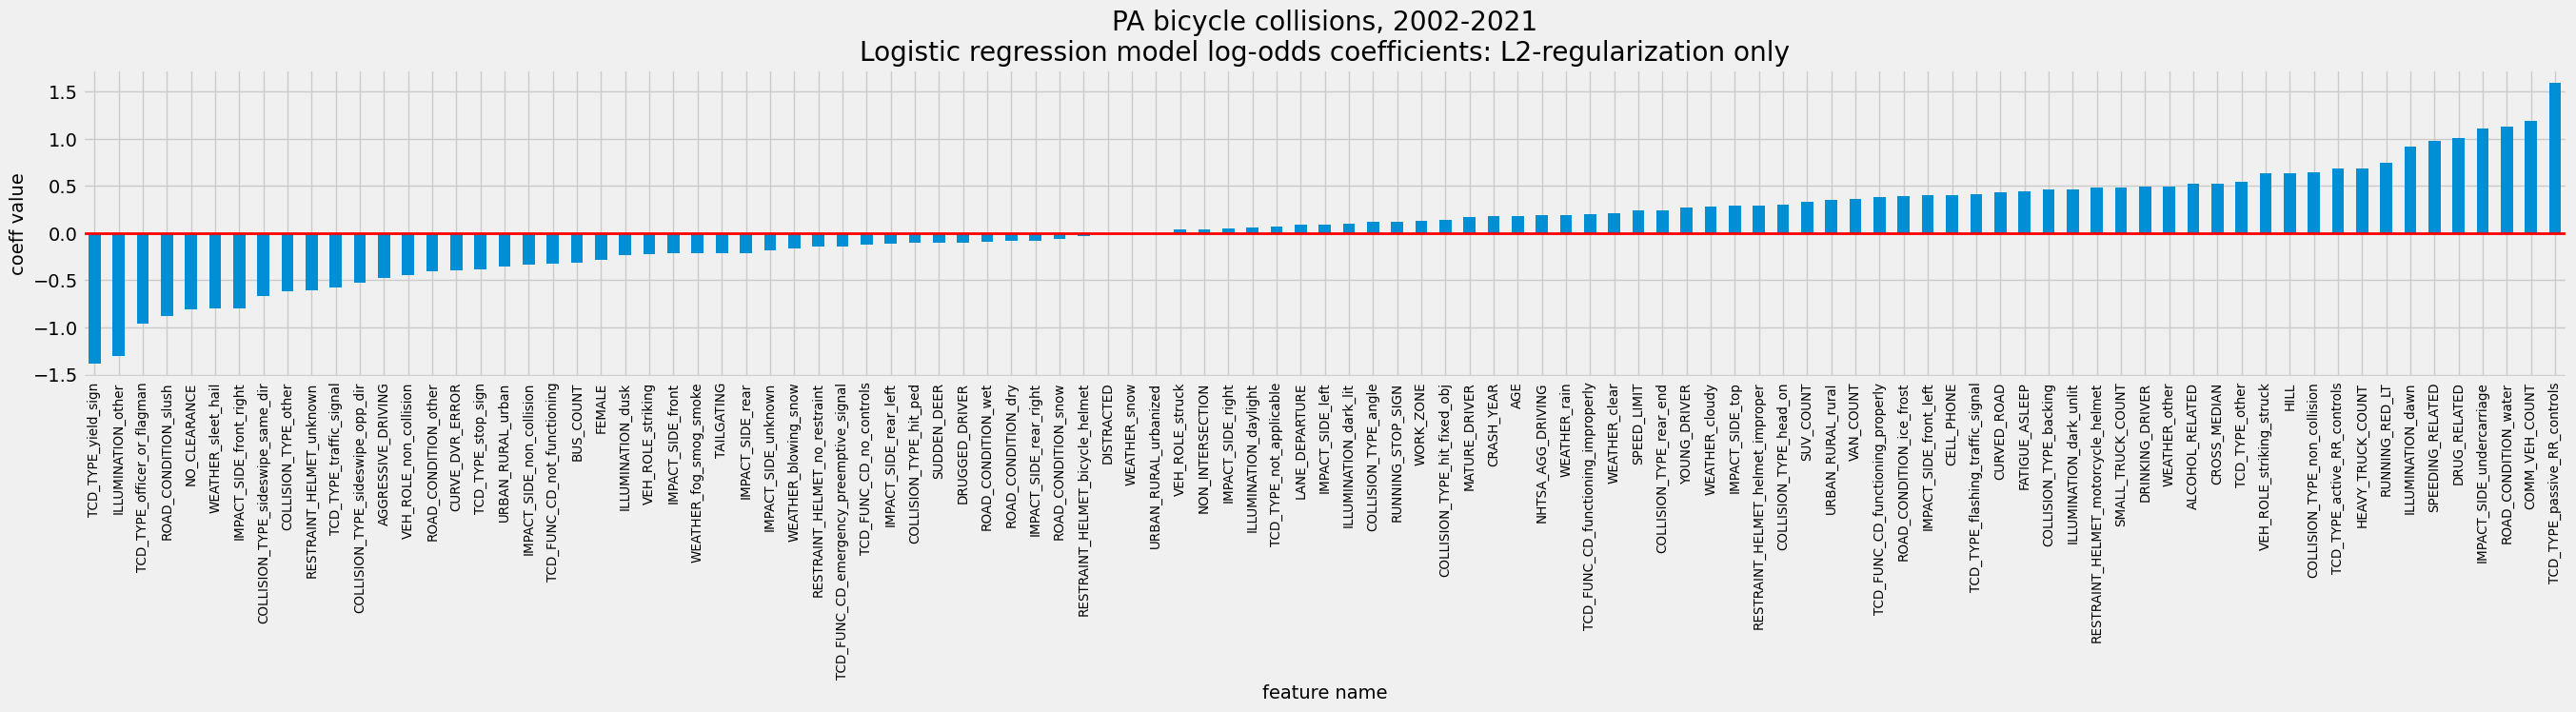

Score on validation set: 0.72338032152522


In [13]:
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',class_weight='balanced')
study = LRStudy(clf,X_train,y_train)
study.build_pipeline()
study.plot_coeff(title_add = 'L2-regularization only')

The horizontal line drawn at y=0 is intended to help us to more easily visually distinguish between features which have positive and negative effects on the log-odds. There are no features with zero coefficients, but many have very small coefficients.  They don't have a significant influence on the model and L1 regularization will likely push them to zero.

##### SAGA solver (L1-regularization only)
We start with an out-of-the-box L1-regularized logistic regression classifier.

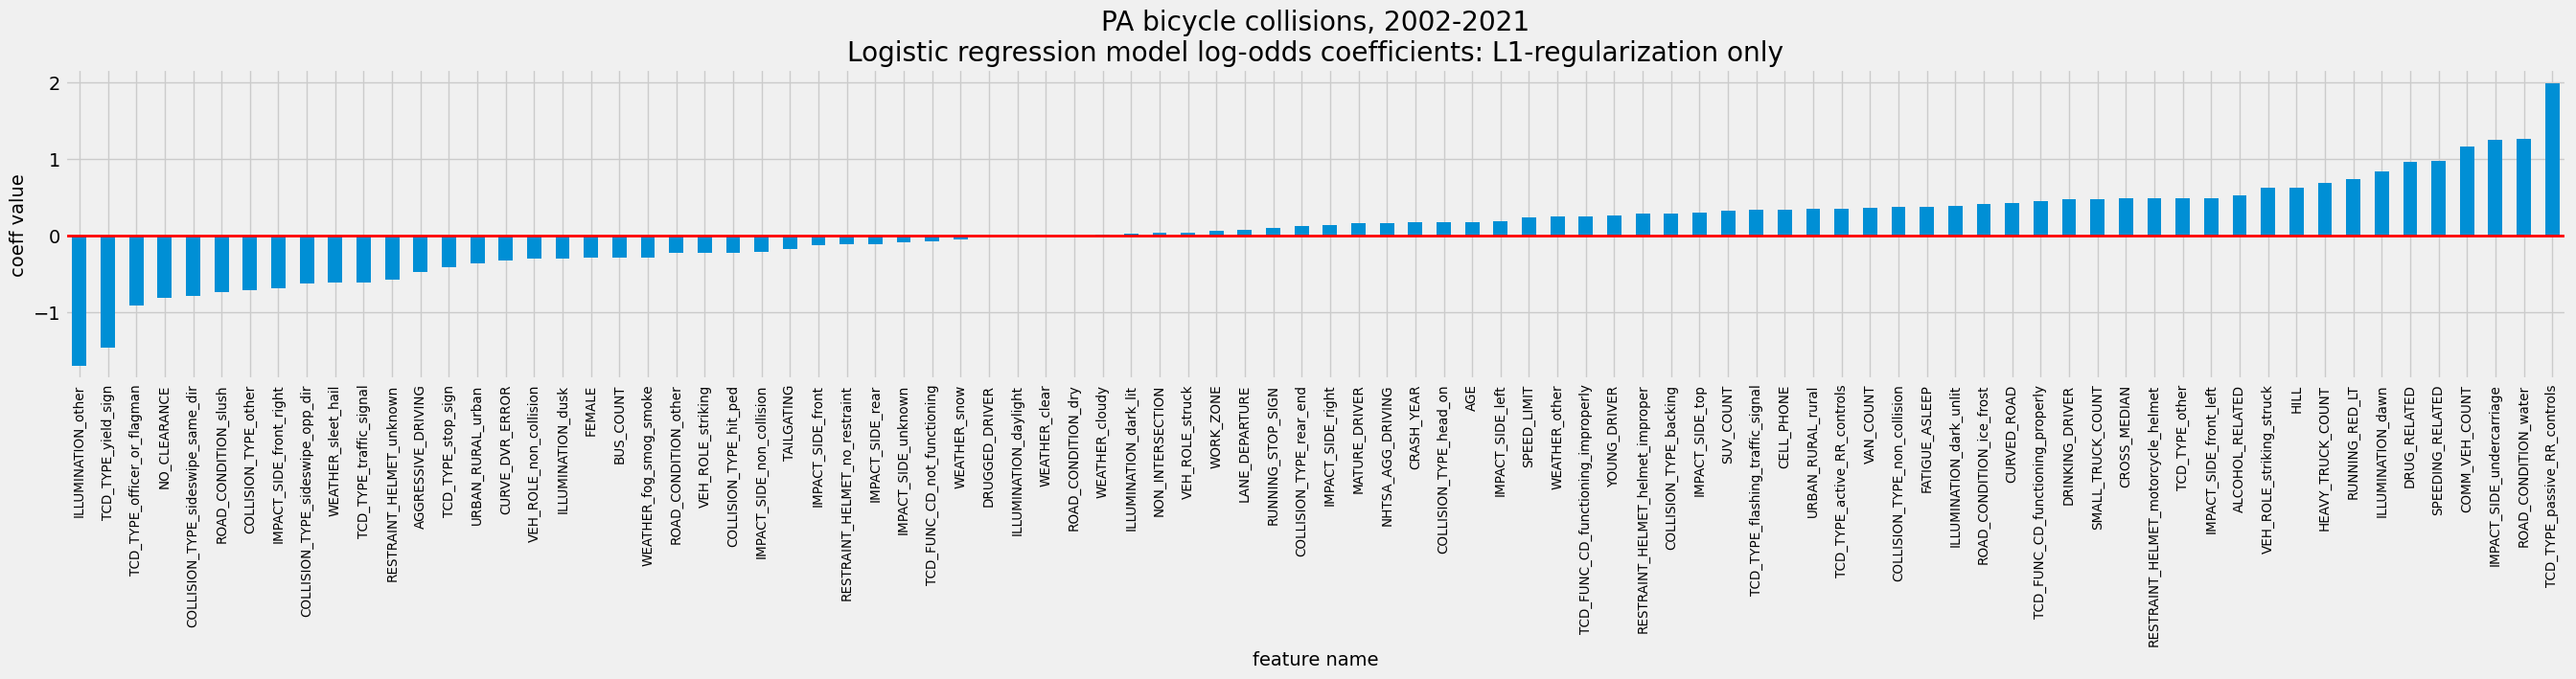

Score on validation set: 0.7230123223479955


In [14]:
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced')
study = LRStudy(clf,X_train,y_train)
study.build_pipeline()
study.plot_coeff(title_add = 'L1-regularization only')

We see some coefficients indeed have zero coefficients, but there remain some nonzero coefficients that are quite small.  If we decrease the hyperparameter C (the inverse of the regularization strength), we can push more towards zero.  We just tried its default value of 1.0 - let's try 0.1.

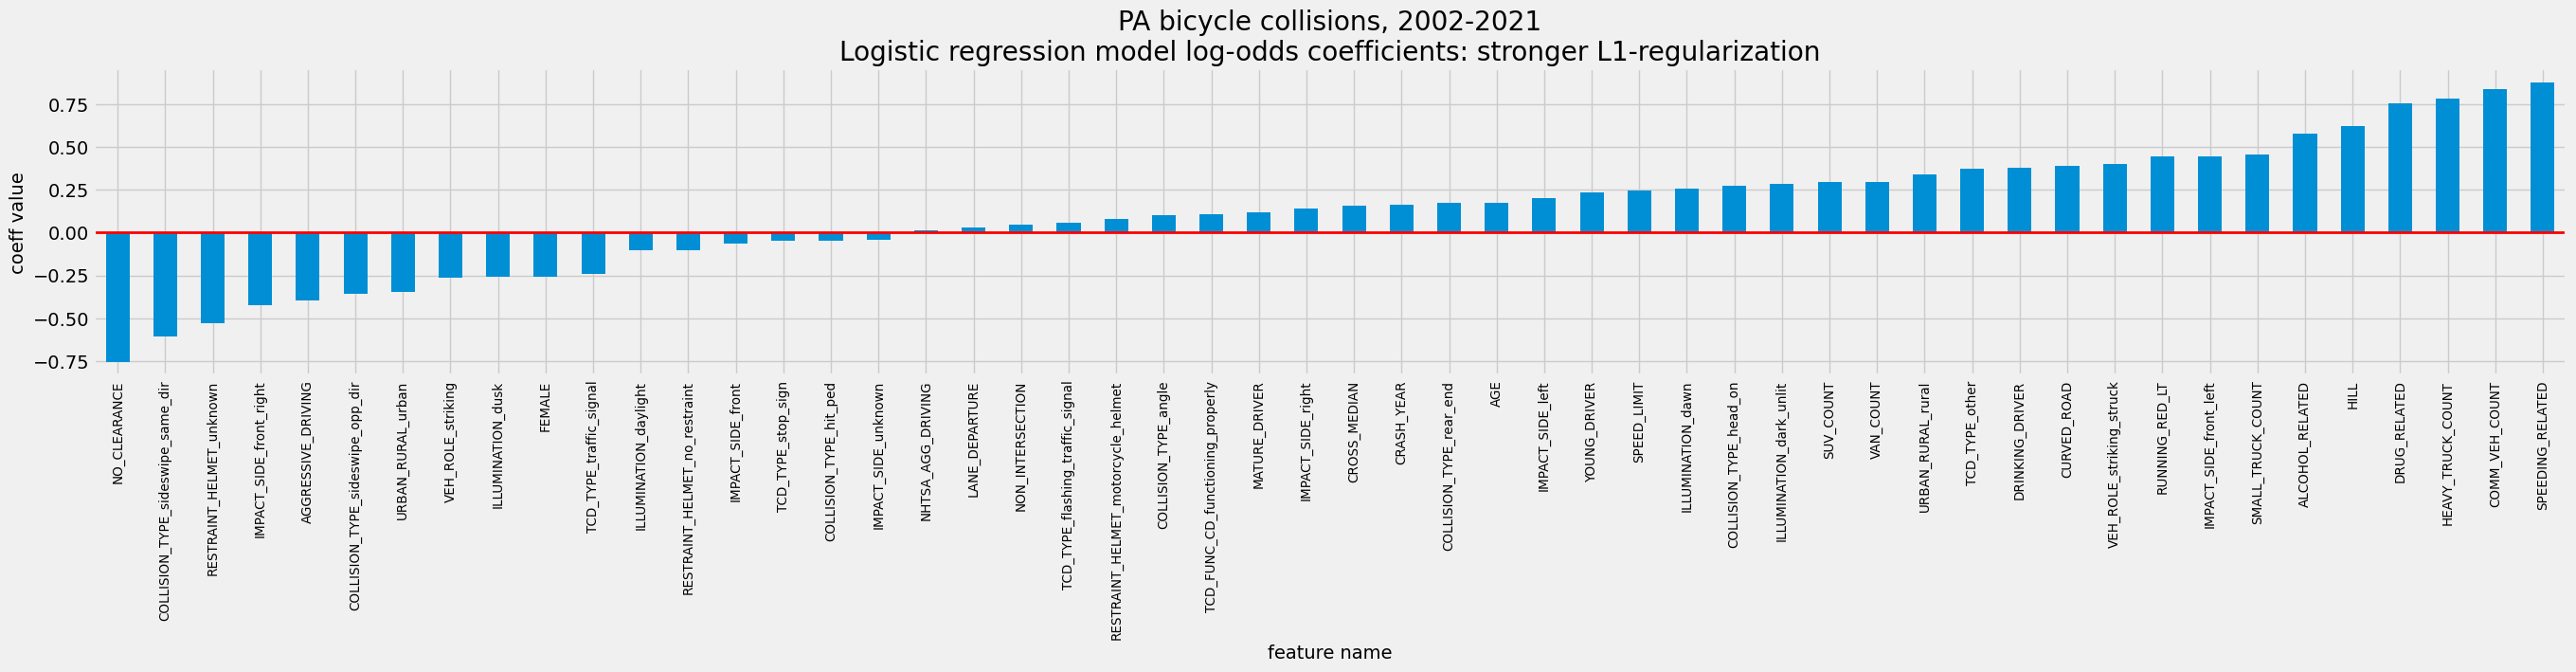

Score on validation set: 0.7272684176356776


In [15]:
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced',C=0.1)
study = LRStudy(clf,X_train,y_train)
study.build_pipeline()
study.plot_coeff(title_add = 'stronger L1-regularization')

We've pushed lots more coefficients to zero, and also raised our validation score.  In particular, the following have zero coefficients in our model:
* All one-hot features associated to WEATHER and ROAD_CONDITION
* The binary features CURVE_DVR_ERROR, DRUGGED_DRIVER, DISTRACTED, FATIGUE_ASLEEP, CELL_PHONE, TAILGATING, SUDDEN_DEER, WORK_ZONE
* The ordinal feature BUS_COUNT
* Some, but not all, one-hot features associated to TCD features, ILLUMINATION, COLLISION_TYPE, IMPACT_SIDE, RESTRAINT_HELMET, VEH_ROLE, URBAN_RURAL.

In a model with L1-regularization at least this strong, it appears safe to remove the features in the first three bullet points above without performance loss.  We're going to keep TAILGATING and CURVE_DVR_ERROR, however - we want to see how they interacts with AGGRESSIVE_DRIVING.

Let's go ahead and make a list of feature type lists with the aforementioned features removed, and make sure our SAGA model tolerates dropping them.

In [16]:
for tcd_type in ['traffic_signal','flashing_traffic_signal','stop_sign']:
    cyclists[f'TCD_{tcd_type}'] = (cyclists.TCD_TYPE==tcd_type).astype(int)
# cyclists['TCD_functioning'] = (cyclists.TCD_FUNC_CD=='functioning_properly').astype(int)

feat_dict['all']['bin'] += [f'TCD_{tcd_type}' for tcd_type in ['traffic_signal','flashing_traffic_signal','stop_sign']]

df = cyclists[[feat for feat_type in feat_dict['all'] for feat in feat_dict['all'][feat_type]]+[TARGET]]
X = df.drop(TARGET,axis=1)
y= df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

feat_dict['lr_small'] = {}

drop_feat = ['BUS_COUNT','WEATHER','ROAD_CONDITION',
             'TCD_TYPE','TCD_FUNC_CD',
             'DISTRACTED','DRUGGED_DRIVER',
            'FATIGUE_ASLEEP', 'CELL_PHONE',
            'SUDDEN_DEER', 'WORK_ZONE']

for feat_type in feat_dict['all']:
    feat_dict['lr_small'][feat_type] = [feat for feat in feat_dict['all'][feat_type] if feat not in drop_feat]

for tcd_type in ['traffic_signal','flashing_traffic_signal','stop_sign']:
    feat_dict['all']['bin'].remove(f'TCD_{tcd_type}')

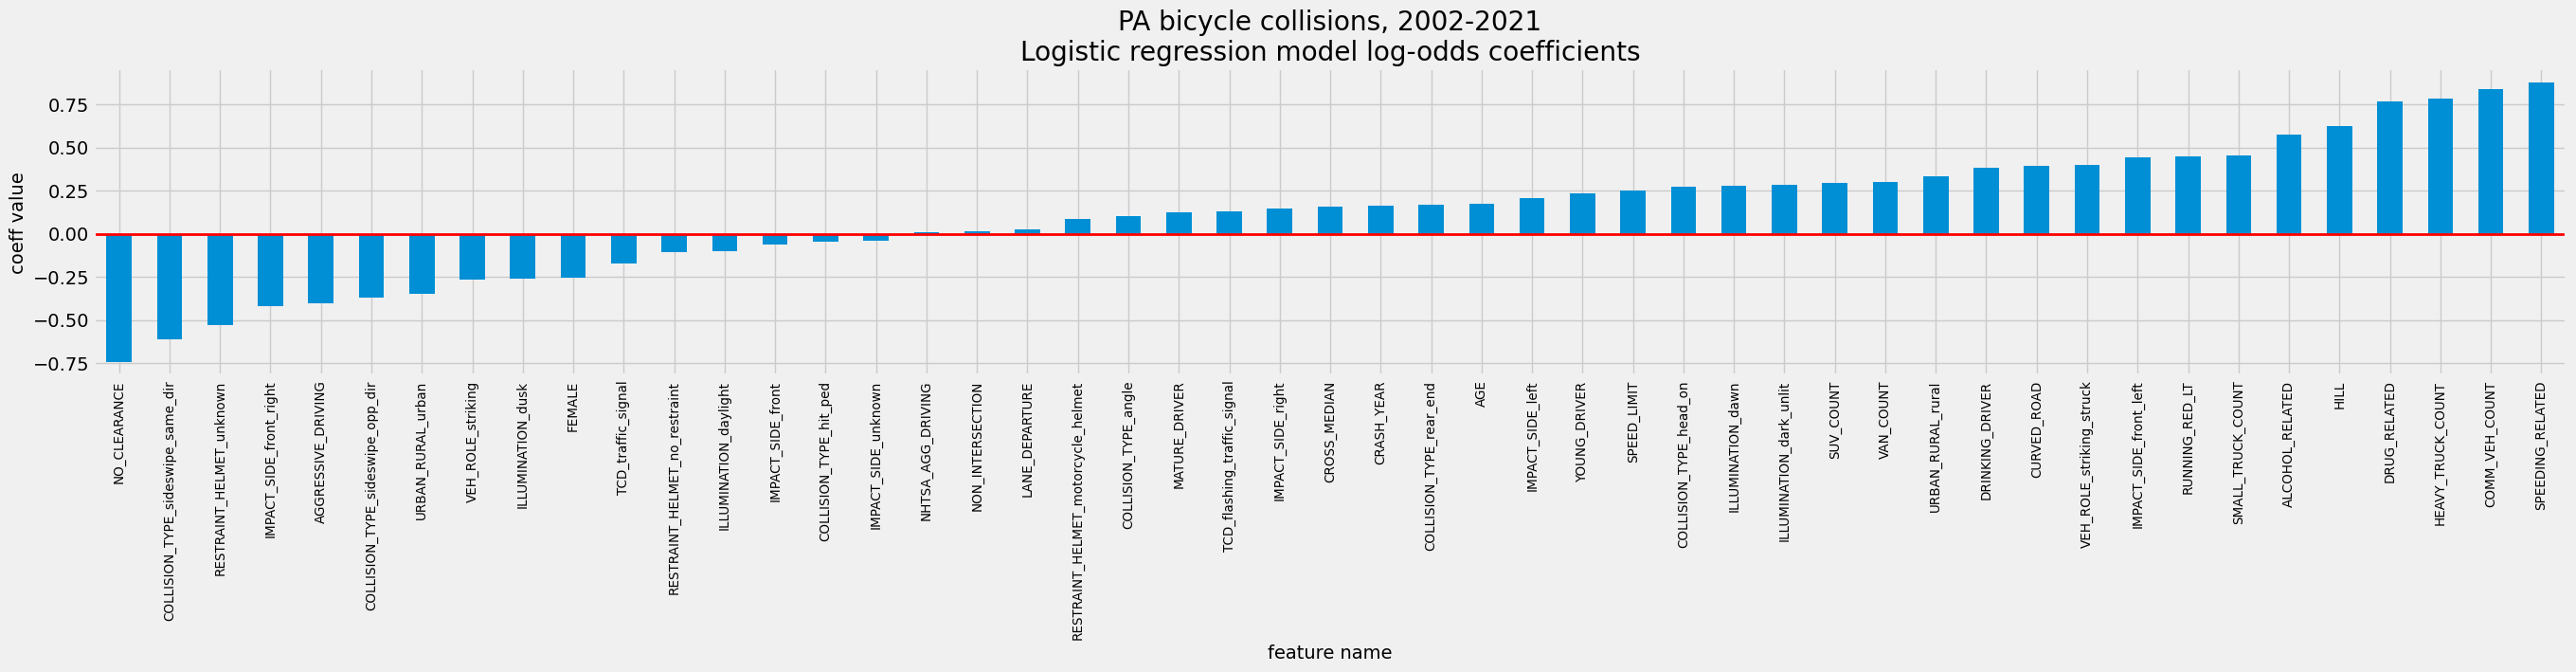

Score on validation set: 0.7285845369638301


In [17]:
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced',C=0.1)
study = LRStudy(clf,X_train,y_train,features=feat_dict['lr_small'])
study.build_pipeline()
study.plot_coeff('stronger L1-regularization and fewer features')

Indeed no loss in validation score! Let's take a closer look at the features with largest coefficients, as they are most impactful to the model.  We'll list just those whose coefficient magnitude is greater than 0.25:

In [18]:
large_coeff = study.coeff[np.abs(study.coeff['coeff value'])>0.25].sort_values(by='coeff value',ascending=False)
large_coeff.style.background_gradient(axis=0,gmap=-large_coeff['coeff value'],cmap='RdBu')

,coeff value
feature name,
SPEEDING_RELATED,0.875878
COMM_VEH_COUNT,0.839966
HEAVY_TRUCK_COUNT,0.781878
DRUG_RELATED,0.763947
HILL,0.621777
ALCOHOL_RELATED,0.573957
SMALL_TRUCK_COUNT,0.453066
RUNNING_RED_LT,0.446190
IMPACT_SIDE_front_left,0.441553


<a id="logistic_cv"></a>
#### Five-fold cross-validation with baseline models

Let's establish some CV-scores for our two baseline models, and we'll go ahead and use the reduced feature set for both.

##### Newton-Cholesky solver

In [19]:
%%time
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',class_weight='balanced',C=0.1)
study_nc = LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_nc.build_pipeline()
study_nc.cv_score()

Mean CV roc_auc score: 0.7372753688357127
CPU times: user 26.5 s, sys: 29.3 s, total: 55.8 s
Wall time: 8.01 s


##### SAGA solver with L1-regularization

In [20]:
%%time
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced',C=0.1)
study_saga = LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_saga.build_pipeline()
study_saga.cv_score()

Mean CV roc_auc score: 0.7360719400632242
CPU times: user 24.1 s, sys: 11.1 s, total: 35.2 s
Wall time: 11 s


The two models seem to perform comparably despite the different regularization methods. Since Newton-Cholesky us a slightly better CV score, we'll proceed with only that one going forward.

<a id="logistic_pca"></a>
#### Dimensionality reduction with PCA

Linear models like logistic regression can often perform well if the data is pre-processed with principle component analysis to reduce the dimensionality and focus on axes with the highest variance.  However, the the optimal number of components in PCA depends on the dataset. We'll use randomized search cross validation to attempt to find an optimal value of n_components.

Let's check the number of features in our transformed X_train, so we know a maximum size for n_components.

In [25]:
study_saga.pipe[:-1].fit_transform(X_train).shape[1]

85

In [30]:
%%time
# Use our randomized_search function so we can try a range of n_components values
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',class_weight='balanced',C=0.1)
study_nc_pca = LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_nc_pca.build_pipeline(pca=True)
study_nc_pca.randomized_search(params={},n_components = list(range(60,86)),n_iter=25)

,mean cv score (roc_auc)
pca__n_components,
76,0.738291
61,0.738240
69,0.738231
74,0.738227
79,0.738211
77,0.738211
84,0.738211
83,0.738211
80,0.738211


CPU times: user 1.41 s, sys: 180 ms, total: 1.59 s
Wall time: 15.4 s


PCA didn't seem to give us much of an improvement.  We won't use it going forward.

<a id="logistic_tuning"></a>
#### Fine tuning hyperparameters

##### Newton-Cholesky

We just tune C, the inverse of the regularization strength, using a log-uniform distribution from 0.02, to 10 (the default value is C=1).

In [33]:
%%time
params = {'C':ss.loguniform(0.02,10)}
study_nc.randomized_search(params,refit=True)

,mean cv score (roc_auc)
LR_clf__C,
0.052738,0.738320
0.052730,0.738319
0.028694,0.738043
0.205070,0.737860
0.825641,0.737017
0.838342,0.737009
1.629659,0.736703
1.890861,0.736649
4.353248,0.736486


CPU times: user 1.27 s, sys: 92.7 ms, total: 1.37 s
Wall time: 5.12 s


##### SAGA with Elastic-Net

The SAGA solver is also compatible with the Elastic-Net penalty, which uses a mixture of L1 and L2 regularization.  The mix is controlled by the value of the parameter l1_ratio:
* l1_ratio = 0 is equivalent to penalty = 'l2'
* l1_ratio = 1 is equivalent to penalty = 'l1'
* intermediate values give a mixture

For good measure, let's try tuning hyperparameters on an Elastic-Net model.  We tune both C and l1_ratio.

In [34]:
%%time
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='elasticnet',class_weight='balanced')
study_saga_en =LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_saga_en.build_pipeline()

params = {'C':ss.loguniform(0.02,10),
         'l1_ratio':ss.uniform(0,1)}

study_saga_en.randomized_search(params,n_iter=50,refit=True)

,,mean cv score (roc_auc)
LR_clf__C,LR_clf__l1_ratio,
0.061911,0.183405,0.738191
0.205070,0.950714,0.738189
0.052738,0.155995,0.738181
0.122891,0.366362,0.738180
0.114621,0.542696,0.738177
0.138154,0.325183,0.738175
0.132486,0.524756,0.738158
0.138781,0.520068,0.738148
0.132792,0.097672,0.738131


CPU times: user 3.44 s, sys: 317 ms, total: 3.76 s
Wall time: 1min 5s


Performance of the best Elastic-Net classifier is about the same as the best one using Newton-Cholesky solver, and Newton-Cholesky is much faster. Overall, the CV scores don't vary much across hyperparameter choices and there are apparently many good options.  We'll proceed with:
* No principal component analysis
* Newton-Cholesky solver (L2-regularization only)
* C-value of 0.052738

<a id="logistic_threshold"></a>
#### $F_{\beta}$ scores - balancing precision and recall to select a classification threshhold

We've used the area under the ROC curve as a metric to help us select hyperparameters, but we haven't yet considered what classification threshold we prefer.  We will consider the $F_{\beta}$ score.

Recall that the $F_{\beta}$ score is a generalization of the $F_1$ score which allows for either precision or recall to be prioritized more strongly over the other.  We should view $\beta$ as the ratio of our perceived importance of recall to importance of precision.

In the task of predicting which cyclists will suffer serious injury or fatality in a crash based on various factors, it seems that recall should be more crucial than precision.  A false positive corresponds to a cyclist who ended up with lesser injury than predicted, which is "good news"; a false negative corresponds to a cyclist suffering an adverse outcome which we failed to predict.

The logistic regression model predicts the probability that a particular sample has class 1 (i.e. suffers serious injury or death), and then the model's class prediction is determined by a threshold we might set when calibrating the model. A typical threshold is 0.5, but it can be adjusted in order to optimize the desired $F_{\beta}$ score.
* We'll fit out best logistic regression classifier again and take a look at various $F_{\beta}$ scores based on values of the threshold and values of $\beta$.
* Since selecting the threshold counts as tuning a hyperparameter, we cannot use the holdout test set to select it.  We'll perform a train/validation split and compute $F_{\beta}$ values on the predictions for the validation set.

In [40]:
nc_params = {'C': 0.05273751067944609}
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',
                         class_weight='balanced',**nc_params)
study_lr =ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_lr.build_pipeline()
study_lr.fit_pipeline(split_first=True)
study_lr.predict_proba_pipeline()

In [45]:
betas = range(1,6)
threshs = [x/100 for x in range(64,69)]

fb_scores = {thresh:[study_lr.score_pipeline(scoring='fb',beta=beta, thresh=thresh,print_score=False) for beta in betas] for thresh in threshs}
fb_scores = pd.DataFrame(fb_scores,index=betas,columns=threshs).rename_axis('beta values',axis=0).rename_axis('threshold values',axis=1)

fb_scores.style.background_gradient(axis=1)

threshold values,0.640000,0.650000,0.660000,0.670000,0.680000
beta values,,,,,
1,0.279330,0.288708,0.297821,0.292191,0.291339
2,0.341344,0.345404,0.349035,0.335260,0.326855
3,0.368623,0.369598,0.370259,0.352584,0.340700
4,0.381166,0.380574,0.379768,0.360248,0.346748
5,0.387689,0.386247,0.384652,0.364163,0.349818


The largest $F_1$ score is around 0.298 (which is pretty low), corresponding to a threshold of 0.66.  This only correctly predicts 123 out of 312 cyclists with serious injury or death.

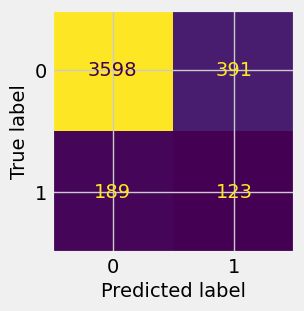

In [47]:
study_nc.score_pipeline(scoring='conf',thresh=0.66)

In [51]:
betas = range(1,6)
threshs = [x/10000 for x in range(2771,2776)]

fb_scores = {thresh:[study_nc.score_pipeline(scoring='fb',beta=beta, thresh=thresh,print_score=False) for beta in betas] for thresh in threshs}
fb_scores = pd.DataFrame(fb_scores,index=betas,columns=threshs).rename_axis('beta values',axis=0).rename_axis('threshold values',axis=1)

fb_scores.style.background_gradient(axis=1)

threshold values,0.277100,0.277200,0.277300,0.277400,0.277500
beta values,,,,,
1,0.160422,0.160466,0.160556,0.160556,0.160044
2,0.318352,0.318422,0.318563,0.318563,0.317530
3,0.473848,0.473926,0.474081,0.474081,0.472518
4,0.593143,0.593214,0.593357,0.593357,0.591376
5,0.677486,0.677547,0.677670,0.677670,0.675386


However, we might choose to consider $F_4$, suggesting that recall is four times as important to use as precision.  To optimize $F_4$, we might choose a classification threshold around 0.2773.  We correctly classify all but 23 of the cyclists with serious injury or fatality, but we end up with around false positives! 

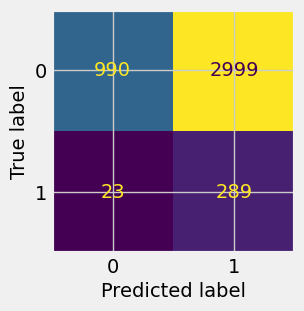

In [52]:
study_nc.score_pipeline(scoring='conf',thresh=0.2773)

We will try to strike a balance and optimize $F_3$.  Let's zoom in to a different region of our $F_{\beta}$ chart:

In [59]:
betas = range(1,6)
threshs = [x/10000 for x in range(4235,4245)]

fb_scores = {thresh:[study_nc.score_pipeline(scoring='fb',beta=beta, thresh=thresh,print_score=False) for beta in betas] for thresh in threshs}
fb_scores = pd.DataFrame(fb_scores,index=betas,columns=threshs).rename_axis('beta values',axis=0).rename_axis('threshold values',axis=1)

fb_scores.style.background_gradient(axis=1)

threshold values,0.423500,0.423600,0.423700,0.423800,0.423900,0.424000,0.424100,0.424200,0.424300,0.424400
beta values,,,,,,,,,,
1,0.211786,0.211786,0.211982,0.212177,0.212471,0.211841,0.211841,0.211841,0.211841,0.211841
2,0.370013,0.370013,0.370251,0.370490,0.370848,0.369593,0.369593,0.369593,0.369593,0.369593
3,0.492716,0.492716,0.492928,0.493139,0.493456,0.491627,0.491627,0.491627,0.491627,0.491627
4,0.570636,0.570636,0.570803,0.570970,0.571220,0.568986,0.568986,0.568986,0.568986,0.568986
5,0.619048,0.619048,0.619176,0.619304,0.619497,0.616995,0.616995,0.616995,0.616995,0.616995


We'll go for a threshold of 0.4239.  This gives 74% on the set of cyclists who were seriously injured or killed cyclists who were correctly classified and 59% recall on those who were not.

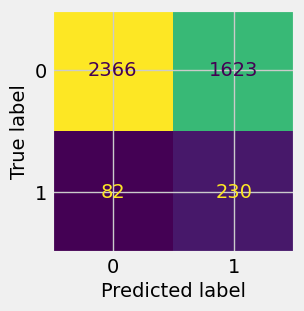

In [62]:
lr_thresh = 0.4239
study_nc.score_pipeline(scoring='conf',thresh=lr_thresh)

In [86]:
study_nc.score_pipeline(scoring='classif_report',thresh=lr_thresh)

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.97      0.59      0.74      3989
         seriously injured or killed       0.12      0.74      0.21       312

                            accuracy                           0.60      4301
                           macro avg       0.55      0.67      0.47      4301
                        weighted avg       0.91      0.60      0.70      4301



<a id="tree"></a>
### Gradient boosted tree classifiers

We will compare our logistic regression results to a gradient-boosted decision tree model.  GradientBoostingClassifier is the original gradient boosted decision tree classifier model in sciki-learn.  HistGradientBoostingClassifier is a histogram-based gradient boosting classification tree model inspired by LightGBM.  Note that HistGradientBoostingClassifer is much faster than GradientBoostingClassifier for big datasets (i.e. n_samples >= 10,000), as we shall see in our computations below.

One advantage of using either of these models is that early stopping is built in - the algorithm will set aside a validation set at the start of training and check model performance on that validation set after each iteration.  If the validation score fails to improve after n_iter_no_change iterations, training is halted effective at the beginning of that waiting period.  In general, letting a decision tree based model train for too many iterations can promote overfitting to the training data, and early stopping can be a valuable measure against this.  By default, the model uses 10% of the samples for a validation set - we'll stick with that setting.

We won't preprocess the data with PCA when using these models, since gradient boosted decision tree algorithms tend not to struggle (as linear models do) with dependencies between input features.

<a id="tree_cv"></a>
#### Baseline CV scores for GBC and HGBC

We'll compute some cross-validation scores for GradientBoostingClassifer and HistGradientBoostingClassifier.  Let's keep using both feature sets to see how they fare.

In [484]:
%%time
clf = GradientBoostingClassifier(n_estimators = 2000, n_iter_no_change=50,random_state=42)
study_gb = ClassifierStudy(clf,X_train,y_train)
study_gb.build_pipeline()
study_gb.cv_score()

Mean CV score: 0.7385016244263062
CPU times: user 196 ms, sys: 124 ms, total: 320 ms
Wall time: 32.4 s


In [766]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42)
study_hgb = ClassifierStudy(clf,X_train,y_train)
study_hgb.build_pipeline()
study_hgb.cv_score()

Mean CV roc_auc score: 0.7310530051375236
CPU times: user 27.9 s, sys: 11.1 s, total: 39.1 s
Wall time: 23.6 s


In [105]:
%%time
clf = GradientBoostingClassifier(n_estimators = 2000, n_iter_no_change=50,random_state=42)
study_gb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_gb_small.build_pipeline()
study_gb_small.cv_score()

Mean CV roc_auc score: 0.7391159294280125
CPU times: user 51.9 s, sys: 115 ms, total: 52 s
Wall time: 52 s


In [125]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42)
study_hgb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_hgb_small.build_pipeline()
study_hgb_small.cv_score()

Mean CV roc_auc score: 0.7320721984002593
CPU times: user 22.7 s, sys: 10.8 s, total: 33.5 s
Wall time: 21.5 s


We notice a few things:
* This scores are comparable to what we achieved with logistic regression models prior to tuning hyperparameters.
* HistGradientBoostingClassifier indeed significantly faster than GradientBoostingClassifier.
* GradientBoostingClassifier seems to get higher mean CV score without tuning hyperparameters.
* Using the smaller feature set increased CV scores slightly with both models, so we'll use the smaller set going forward.

<a id="tree_tuning"></a>
#### Tuning hyperparameters for gradient boosted decision tree models

In [126]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42)
study_hgb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_hgb_small.build_pipeline()
params = {'learning_rate':ss.loguniform(0.005,0.2),
          'max_depth':list(range(2,30))+[None],
          'l2_regularization':ss.loguniform(1,12),
          'min_samples_leaf':ss.randint(20,200),
          }
study_hgb_small.randomized_search(params, n_iter=50, refit=True)

,,,,mean cv score (roc_auc)
clf__l2_regularization,clf__learning_rate,clf__max_depth,clf__min_samples_leaf,
2.423873,0.141829,2.000000,140,0.743990
2.029526,0.005729,18.000000,21,0.742952
4.098751,0.005612,19.000000,63,0.742769
1.039620,0.023839,2.000000,155,0.742640
9.882558,0.006930,24.000000,59,0.742480
3.109450,0.011192,21.000000,49,0.741951
5.000058,0.005010,14.000000,22,0.741862
4.426506,0.008890,20.000000,94,0.741644
1.985423,0.014915,14.000000,84,0.741391


CPU times: user 5.27 s, sys: 746 ms, total: 6.02 s
Wall time: 4min 5s


An improvement in CV score with tuned hyperparameters.  Let's apply this tuned classifier to the holdout set.

In [278]:
%%time
clf = GradientBoostingClassifier(n_estimators = 2000, n_iter_no_change=50,random_state=42)
study_gb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_gb_small.build_pipeline()
params = {'learning_rate':ss.loguniform(0.005,0.2),
          'max_depth':list(range(2,30))+[None],
          'subsample':ss.uniform(0.5,1),
          'min_samples_leaf':ss.randint(20,200),
          }
study_gb_small.randomized_search(params, n_iter = 50, refit=True)

,,,,mean cv score (roc_auc)
clf__learning_rate,clf__max_depth,clf__min_samples_leaf,clf__subsample,
0.006046,6.000000,148,0.739562,0.743638
0.023839,2.000000,155,0.505522,0.741293
0.032902,10.000000,81,0.722108,0.737597
0.014915,14.000000,84,0.515636,0.737133
0.016473,25.000000,199,0.863630,0.737056
0.045505,8.000000,141,0.655995,0.736985
0.107794,7.000000,149,0.681825,0.735254
0.047448,9.000000,194,0.673365,0.734681
0.005010,14.000000,22,0.506952,0.734303


CPU times: user 45.3 s, sys: 442 ms, total: 45.7 s
Wall time: 5min 51s


Hyperparameter tuning improved HistGradientBoostingClassifier more than it did GradientBoostingClassifier, and their optimal CV scores are very similar.  Going forward, we'll stick with HistGradientBoostingClassifier.

<a id="tree_threshold"></a>
#### $F_{\beta}$ and the classification threshold

Let's perform a train/validation split and take a look at $F_{\beta}$ scores for various values of $\beta$ and various thresholds.

In [127]:
hgb_params={'l2_regularization': 2.4238734679222236,
 'learning_rate': 0.14182851952262968,
 'max_depth': 2,
 'min_samples_leaf': 140}

In [128]:
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,n_iter_no_change=50,
                                     random_state=42,**hgb_params)
study_hgb =ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_hgb.build_pipeline()
study_hgb.fit_pipeline(split_first=True)
study_hgb.predict_proba_pipeline()

In [129]:
betas = range(1,6)
threshs = [x/10 for x in range(1,11)]

fb_scores = {thresh:[study_hgb.score_pipeline(scoring='fb',beta=beta, thresh=thresh,print_score=False) for beta in betas] for thresh in threshs}
fb_scores = pd.DataFrame(fb_scores,index=betas,columns=threshs).rename_axis('beta values',axis=0).rename_axis('threshold values',axis=1)

fb_scores.style.background_gradient(axis=1)

threshold values,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.000000
beta values,,,,,,,,,,
1,0.281277,0.326165,0.229665,0.148760,0.083086,0.030960,0.018927,0.000000,0.000000,0.000000
2,0.389021,0.304552,0.177253,0.103926,0.054988,0.019857,0.011971,0.000000,0.000000,0.000000
3,0.445964,0.297970,0.164722,0.094439,0.049418,0.017737,0.010665,0.000000,0.000000,0.000000
4,0.474568,0.295342,0.160063,0.091017,0.047439,0.016990,0.010206,0.000000,0.000000,0.000000
5,0.490112,0.294059,0.157855,0.089415,0.046518,0.016643,0.009994,0.000000,0.000000,0.000000


This table looks a little strange when we compare to the corresponding one we saw for logistic regression!  Notice that although the class distinction is happening at much lower threshold values, we see some $F_{\beta}$ scores that are at least as good as those we saw with logistic regression.  The best value of $F_{3}$ in the table occurs at or below a threshold of 0.1, so let's zoom in quite a bit.

In [130]:
betas = range(1,6)
threshs = [x/10000 for x in range(599,605)]

fb_scores = {thresh:[study_hgb.score_pipeline(scoring='fb',beta=beta, thresh=thresh,print_score=False) for beta in betas] for thresh in threshs}
fb_scores = pd.DataFrame(fb_scores,index=betas,columns=threshs).rename_axis('beta values',axis=0).rename_axis('threshold values',axis=1)

fb_scores.style.background_gradient(axis=1)

threshold values,0.059900,0.060000,0.060100,0.060200,0.060300,0.060400
beta values,,,,,,
1,0.226203,0.226434,0.226667,0.227249,0.226571,0.225207
2,0.382353,0.382618,0.382883,0.383547,0.382210,0.379526
3,0.496629,0.496853,0.497076,0.497636,0.495719,0.491877
4,0.566325,0.566496,0.566667,0.567094,0.564784,0.560157
5,0.608558,0.608686,0.608815,0.609138,0.606575,0.601443


It appears that a threshold around 0.0602 would optimize $F_3$.  Let's take a look at the confusion matrix in this case.

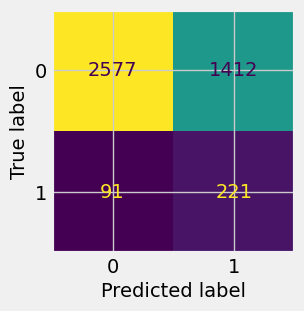

In [131]:
hgb_thresh = 0.0602
study_hgb.score_pipeline(scoring='conf',thresh=hgb_thresh)

In [132]:
study_hgb.score_pipeline(scoring='classif_report',thresh=hgb_thresh)

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.97      0.65      0.77      3989
         seriously injured or killed       0.14      0.71      0.23       312

                            accuracy                           0.65      4301
                           macro avg       0.55      0.68      0.50      4301
                        weighted avg       0.91      0.65      0.73      4301



We're able to correctly classify 71% of cyclists who suffered serious injury or fatality, and 65% of those who didn't.

But what explains this small threshold? Recall that in our logistic regression models we used the parameter class_weight='balanced', a measure that can help those models significantly in the presence of class imbalance.  Given that our training set is fairly large and our class imbalance is not particularly extreme (a 90%-10% split as opposed to a 99%-1% split or worse), tree and forest models should still be able to learn the minority class relatively well.  However, they will still be 'less confident' at predicting the minority class, i.e. the predicted probabilities will be scaled down and require smaller thresholds for class distinction.

If we want to address this anyhow, we can use class_weight='balanced' in HGBC as well! Note that this option isn't built in to the ordinary GBC.

In [133]:
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,n_iter_no_change=50,class_weight='balanced',
                                     **hgb_params,random_state=42)
study_hgb =ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_hgb.build_pipeline()
study_hgb.fit_pipeline(split_first=True)
study_hgb.predict_proba_pipeline()

In [134]:
betas = range(1,6)
threshs = [x/10000 for x in range(4224,4230)]

fb_scores = {thresh:[study_hgb.score_pipeline(scoring='fb',beta=beta, thresh=thresh,print_score=False) for beta in betas] for thresh in threshs}
fb_scores = pd.DataFrame(fb_scores,index=betas,columns=threshs).rename_axis('beta values',axis=0).rename_axis('threshold values',axis=1)

fb_scores.style.background_gradient(axis=1)

threshold values,0.422400,0.422500,0.422600,0.422700,0.422800,0.422900
beta values,,,,,,
1,0.220595,0.220811,0.220919,0.221027,0.220264,0.220264
2,0.378559,0.378813,0.378940,0.379067,0.377644,0.377644
3,0.497250,0.497469,0.497578,0.497688,0.495704,0.495704
4,0.570962,0.571131,0.571216,0.571301,0.568942,0.568942
5,0.616127,0.616256,0.616321,0.616385,0.613787,0.613787


This chart looks more reasonable, and we see a threshold of 0.4227 giving us an optimal $F_3$ score.  The confusion matrix is very similar - it wasn't particularly necessary to use balanced class weighting.

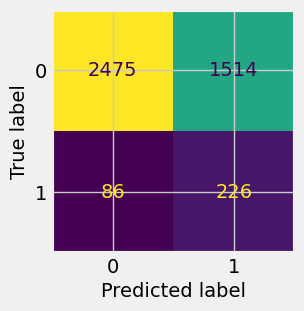

In [135]:
study_hgb.score_pipeline(scoring='conf',thresh=0.4217)

<a id="select"></a>
### Selecting our BikeSafePA model

We'll choose between the best logistic regression classifier and the best histogram-based gradient boosting classifier based on an array of their cross-validation scores according to various metrics.

In [121]:
def cv_scores_dict(clf,thresh):
    study = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
    study.build_pipeline()
    scores_dict = {}
    for scoring in ['roc_auc','fb','f1w','acc']:
        scores_dict[scoring] = [study.cv_score(scoring=scoring,beta=3,thresh=thresh,
                                              return_mean_score=True, print_mean_score=False)]
    return scores_dict

In [122]:
%%time
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',
                         class_weight='balanced',**nc_params)
lr_cv = cv_scores_dict(clf,lr_thresh)

CPU times: user 2min 17s, sys: 1min 32s, total: 3min 50s
Wall time: 33.3 s


In [123]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42,
                                    **hgb_params)
hgb_cv = cv_scores_dict(clf,hgb_thresh)

CPU times: user 1min 55s, sys: 17.5 s, total: 2min 12s
Wall time: 1min 5s


In [124]:
# Define table styles
styles = [dict(selector="caption",
                props=[("text-align", "center"),
                        ("font-size", "100%"),
                        ("color", 'black'),
                        ("text-decoration","underline"),
                        ("font-weight","bold")])]
    
cv_scores = pd.concat([pd.DataFrame(lr_cv,index=['Optimal LogisticRegression model']),
                       pd.DataFrame(hgb_cv,index=['Optimal HistGradientBoostingClassifier model'])],axis=0)\
            .rename(columns = {'roc_auc':'ROC AUC score','fb': 'F_beta score (beta=3)',
                               'f1w':'weighted average F_1 score','acc':'accuracy score'})
cv_scores.style.set_caption('Comparison of model CV scores (n_splits=5, n_repeats = 3)')\
                .set_table_styles(styles)

,ROC AUC score,F_beta score (beta=3),weighted average F_1 score,accuracy score
Optimal LogisticRegression model,0.737482,0.496447,0.700887,0.608091
Optimal HistGradientBoostingClassifier model,0.743733,0.495887,0.735962,0.652360


**Although the logistic regression model attained slightly higher $F_3$ score, the gradient boosted decision tree model performed better in ROC AUC score. We select  model as our BikeSafePA model.  However, we proceed to evaluate the performance of both models on the test set in the next section for illustrative purposes.**

<a id="eval"></a>
### Evaluating model performance on the holdout set

We compute the AUC score for each of our best classifiers on the holdout test set, and display the confusion matrix and classification report that we obtain with our chosen thresholds.

In [136]:
def test_scores_dict(clf,thresh):
    study = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
    study.build_pipeline()
    study.fit_pipeline()
    study.predict_proba_pipeline(X_test)
    scores_dict = {}
    for scoring in ['roc_auc','fb','f1w','acc']:
        scores_dict[scoring] = [study.score_pipeline(y_test,scoring=scoring,beta=3,
                                                     thresh=thresh,print_score=False)]
    return (study,scores_dict)

clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',
                         class_weight='balanced',**nc_params)
study_lr,lr_test = test_scores_dict(clf,lr_thresh)

clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42,
                                    **hgb_params)
study_hgb,hgb_test = test_scores_dict(clf,hgb_thresh)

test_scores = pd.concat([pd.DataFrame(lr_test,index=['Optimal LogisticRegression model']),
                       pd.DataFrame(hgb_test,index=['Optimal HistGradientBoostingClassifier model'])],axis=0)\
            .rename(columns = {'roc_auc':'ROC AUC score','fb': 'F_beta score (beta=3)',
                               'f1w':'weighted average F_1 score','acc':'accuracy score'})
test_scores.style.set_caption('Comparison of model scores on holdout test set')\
                .set_table_styles(styles)

,ROC AUC score,F_beta score (beta=3),weighted average F_1 score,accuracy score
Optimal LogisticRegression model,0.713692,0.477729,0.685787,0.589362
Optimal HistGradientBoostingClassifier model,0.722509,0.477130,0.727227,0.640878


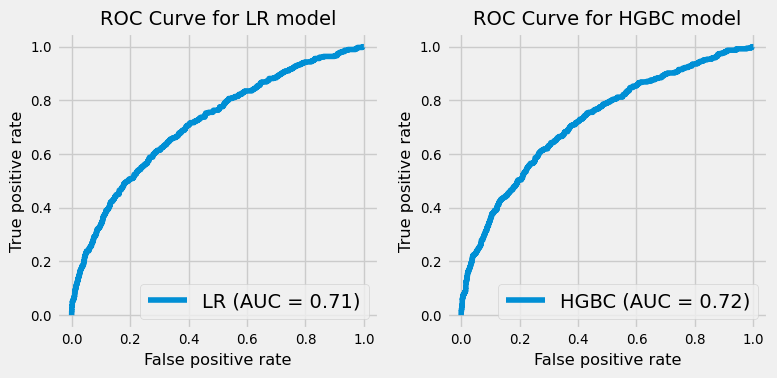

In [138]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
RocCurveDisplay.from_predictions(y_test,study_lr.y_predict_proba,
                                 name='LR',ax=axs[0])
axs[0].set_title('ROC Curve for LR model',fontsize='medium')
RocCurveDisplay.from_predictions(y_test,study_hgb.y_predict_proba,
                                 name='HGBC',ax=axs[1])
axs[1].set_title('ROC Curve for HGBC model',fontsize='medium')
for ax in axs:
    ax.tick_params(axis='x', labelsize='x-small')
    ax.tick_params(axis='y', labelsize='x-small')
    ax.set_ylabel('True positive rate',fontsize='small')
    ax.set_xlabel('False positive rate',fontsize='small')
plt.tight_layout()
plt.show()

A classifer with an AUC score of 0.71-0.72 is generally considered "acceptible".

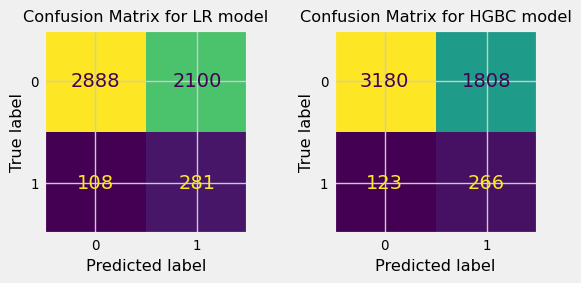

In [139]:
fig, axs = plt.subplots(1,2,figsize=(6,3))
ConfusionMatrixDisplay.from_predictions(y_test,(study_lr.y_predict_proba >= lr_thresh).astype(int),
                                        ax=axs[0],colorbar=False)
axs[0].set_title('Confusion Matrix for LR model',fontsize='small')
ConfusionMatrixDisplay.from_predictions(y_test,(study_hgb.y_predict_proba >= hgb_thresh).astype(int),
                                       ax=axs[1],colorbar=False)
axs[1].set_title('Confusion Matrix for HGBC model',fontsize='small')
for ax in axs:
    ax.tick_params(axis='x', labelsize='x-small')
    ax.tick_params(axis='y', labelsize='x-small')
    ax.set_ylabel('True label',fontsize='small')
    ax.set_xlabel('Predicted label',fontsize='small')
plt.tight_layout()
plt.show()

Finally, the classification reports for each model:

In [140]:
study_lr.score_pipeline(y_test,scoring='classif_report',thresh=lr_thresh)

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.96      0.58      0.72      4988
         seriously injured or killed       0.12      0.72      0.20       389

                            accuracy                           0.59      5377
                           macro avg       0.54      0.65      0.46      5377
                        weighted avg       0.90      0.59      0.69      5377



In [141]:
study_hgb.score_pipeline(y_test,scoring='classif_report',thresh=hgb_thresh)

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.96      0.64      0.77      4988
         seriously injured or killed       0.13      0.68      0.22       389

                            accuracy                           0.64      5377
                           macro avg       0.55      0.66      0.49      5377
                        weighted avg       0.90      0.64      0.73      5377



<a id="shap"></a>
### Explaining BikeSafePA's predictions using SHAP values

Machine learning models can be difficult to interpret, and one excellent candidate for an interpretation method comes in the form of SHAP (SHapley Additive exPlanation) values.  These values attribute to each feature and each sample the change in expected model prediction when conditioning on that feature, i.e. when adding that feature to the model.  Note that when features are not independent or when the model is non-linear, the order in which features are added has an impact on the changes in expectation they generate. The SHAP value of a feature is really an average of its impact to expectation, where the average is taken over all possible orders in which features can be added.

We have built methods into ClassifierStudy to calculate and plot SHAP values.  We'll compute and examine SHAP values for BikeSafePA, our best HistGradientBoostingClassifier model.  Since spline feature importance will be difficult to interpret, we'll use a version of our model that doesn't use DAY_OF_WEEK or HOUR_OF_DAY by setting cyc_method=None in our build_pipeline method.



<a id="shap_plots"></a>
#### SHAP plots

Some remarks about the plots below:
* The right hand plot is a 'violin' plot which shows the accumulations of SHAP values of all samples, for each feature, color-coded by the value of that feature.
* The left hand plot is a bar plot which show the mean absolute SHAP value (the mean of the absolute values of the SHAP values, where the mean is taken over all samples in the test set) for each feature.  We have clipped off features that have particularly low mean absolute SHAP values.
* When reading the beeswarm plot, we should pay attention to the apparent relationship between feature value (i.e. color) and SHAP value - is the SHAP value increasing as or decreasing as the color becomes more red, and how fast?
* We should be cautious when using the bar plots.  A feature which is very important for few samples and not very important for the rest will have a small mean absolute SHAP value.

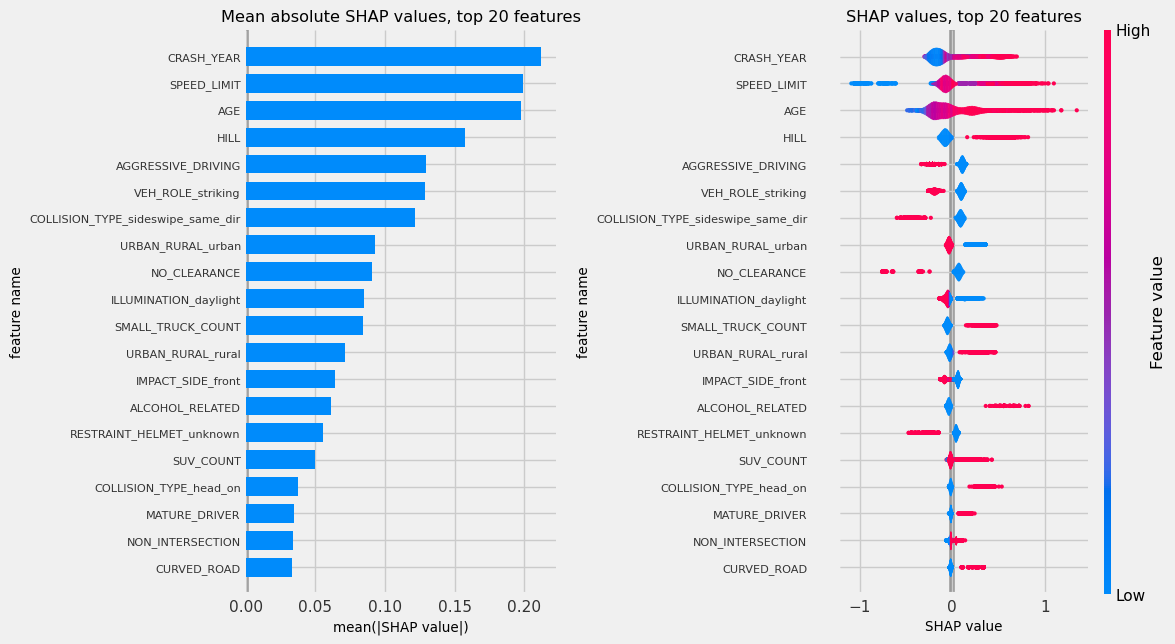

CPU times: user 9 s, sys: 325 ms, total: 9.32 s
Wall time: 6.92 s


In [142]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,n_iter_no_change=50,
                                     **hgb_params,random_state=42)
study_hgb = ClassifierStudy(clf,X_train,y_train,features=feat_dict['lr_small'])
study_hgb.build_pipeline(cyc_method=None,num_ss=False)
study_hgb.shap_values(X_test)
study_hgb.shap_plot(max_display=20)

<a id="shap_fi"></a>
#### Discussing of feature importance from SHAP values

##### Summary of charts

The model is pushed towards predicting serious injury or fatality when a cyclist...
* ... has an age greater than 30 is male (stronger push for higher age)
* ... is in a crash involving a SUV, truck, van, or commercial vehicle.  The push is stronger when there are two such vehicles, but the strength of the push is highly variable when they're present which suggests interaction with other features.

When the following factors are present, they push the model towards predictiong serious injury or fatality:
* Strong push: SPEEDING_RELATED, ALCOHOL_RELATED, DRINKING_DRIVER, DRUG_RELATED,
* Moderate push: CURVED_ROAD, YOUNG_DRIVER, MATURE_DRIVER
* Weak push: NON_INTERSECTION, NHTSA_AGG_DRIVING, RUNNING_RED_LT, LANE_DEPARTURE

When these factors are present, they push the model away predictiong serious injury or fatality:
* Strong push: NO_CLEARANCE
* Moderate push: AGGRESSIVE_DRIVING

Note that AGGRESSIVE_DRIVING ends up with a much higher mean absolute SHAP value than NO_CLEARANCE because proceeding without clearance after a stop is an example of aggressive driving - as are running red light, running stop sign, speeding, racing, or going too fast for the conditions.

For one-hot features arising from categorical features:
* VEH_ROLE:  pushes the model moderately towards predicting serious injury or fatality when the cyclist is both striking and struck, and moderately away when only striking.
* COLLISION_TYPE: pushes the model heavily towards predicting serious injury or fatality when it's head-on, moderately towards when it's rear-end, and moderately away when it's sideswipe in either direction.  There's a neutral effect when the collision is angled, which is by far the most common type.
* IMPACT_SIDE: pushes model moderately towards prediction serious injury or fatality when it's left side, moderately away when it's front.  Other impact sides have weaker or neutral effects on average.
* URBAN_RURAL: pushed the model moderately towards predicting serious injury or fatality when it's rural, and moderately away when it's urban.  Urbanized has a very weak positive effect.
* ILLUMINATION: pushes the model moderately away from predicting serious injury or fatality when daylight, and moderately toward when dark_unlit.  Other effects area weak or neutral, but note that there is high variability when dark_lit, suggesting interactions with other features.
* RESTRAINT_HELMET: pushes the model strongly away from predicting serious injury or fatality when is unknown, and towards to a highly varying degree when is bicycle_helmet.  Others have neutral effect, including no_helmet which is the vast majority of samples.
* All TCD_TYPE features have essentially zero importance.

##### Other comments:

* It seems surprising that the presence of AGGRESSIVE_DRIVING pushes the model away from predicting serious injury or fatality.  However, there are several factors to consider:
    * NO_CLEARANCE perhaps has a negative effect on severity because one or more of the colliding drivers would be traveling relatively slowly in such a scenario - unfortunately, we don't have access to complete travel speed data in order to test this. However, a negative effect from NO_CLEARANCE will partially drive the negative effect from AGGRESSIVE_DRIVING.
    * Although SPEEDING_RELATED and RUNNING_RED_LT are aggressive driving behaviors that push the model towards predicting serious injury or fatality, others such as TAILGATING and RUNNING_STOP_SIGN appear to have weak effects.  There are still more aggressive driving behaviors that don't have flags in this dataset.
    * Even when AGGRESSIVE_DRIVING==1, we don't know which driver is exhibiting the behavior - and probably aggressive driving on the part of a cyclist would differ in effect from that on the part of a motorist.
* The model seems to confirm the sentiment that a bicycle helmet won't provide much protection in an impact with a motor vehicle - they're not necessarily designed to reduce the change of serious injury or death in impacts with cars.  Helmets tend to offer better protection at lower crash speeds, and we've already seen that lower speed limit has a negative forcing effect on prediction of serious injury or fatality.

<a id="summary"></a>
### Summary of process and results

We developed two types of classifier models in order to predict whether a cyclist suffered serious injury or fatality: logistic regression and gradient boosted decision tree models.  Models were evaluated on the ROC-AUC score, and then prediction thresholds were chosen by analyzing $F_{\beta}$ scores.

##### Feature selection

We first selected features by based on their log-odds coefficient values in a fitted LogisticRegression model (with purely L1 regularization, to promote sparsity of the coefficients).  Specifically, we omitted some features which had zero or very small coefficients, suggesting they're not very important to the model's expressability.  It's crucial here that we applied standard scaling to our numerical features ahead of time - if features are at vastly different scales, then their log-odds coefficients can provide misleading information.
This reduced set of features was used to construct both logistric regression and gradient boosted tree models.

##### Feature encoding

We encoded features in several ways:
* One-hot encoding was applied to categorical features
* Standardizing was applied to numerical features (i.e. rescaled to mean 0 and variance 1)
* After considering several options for the cyclical features DAY_OF_WEEK and HOUR_OF_DAY, we ultimately chose periodic spline encoding based on its performance and efficiency
* Binary features, as well as ordinal features of the form vehictle_COUNT, were left unchanged

This encoding was automated via a custom model pipeline.

##### Hyperparameter tuning

We examined several logistic regression and gradient boosted decision tree models with a wide variety of hyperparameter settings.  After tuning hyperparameters to optimize ROC-AUC score via randomized search with five-fold cross validation, our two best models were:
* A LogisticRegression model with only L2-regularization and C-value (the inverse of the regularization strength) roughly equal to 0.053.
* A HistGradientBoostingClassifer model (for its computational speed) with learning rate = 0.142, max tree depth of 2, minimum samples per leaf of 140, and L2 regularization parameter around 2.4; all other hyperparameters were left at defualt values.  We set the number of iterations to be very large, and used early stopping to end our training.

The ROC-AUC score is computed based on how the model's predicted probabilities affect the true positive and true negative rates at all possible prediction thresholds, and so optimizing the AUC doesn't on its own provide a choice for the best prediction threshold.  We selected prediction thresholds for both models which optiized the $F_3$ score, a variant of the classical $F_1$ score which considers recall of the positive class (serious cyclist injury or cyclist fatality) as three times as important as important as recall of the negative class.

##### Selecting the BikeSafePA model

**Based on its performance with respect to ROC-AUC score, we selected the gradient boosted tree algorithm as our BikeSafePA model!**

<figure>
<img src="hgb_roc.png" width="25%"><img src="hgb_conf.png" width="25%">
    <figcaption align="center">The ROC curve and confusion matrix for the BikeSafePA classifier model.</figcaption>
</figure>
    
When trained on the entire training set and scored on the holdout test set, BikeSafePA attains ROC-AUC score of around 0.72.  Using the classification threshold values we selected in the parameter tuning phase, the model correctly classifies 68% of cyclists in the test set who suffered serious injury or fatality, and correctly classifies 64% of those who didn't.  We set the threshold to optimize the $F_3$ score, a variant of the $F_1$ score which views recall as three times as important as precision; adjusting it further could produce variants which are better at identifying cyclists at risk of serious injury or death, but they would also accumulate more false positives.  The end-user of BikeSafePA should adjust its classification threshold to accomodate the needs of their particular use case.

<a id="model_reflection"></a>
### Reflections on BikeSafePA's performance

Despite that large number of features, there are some challenges which limit performance:
* Although we have a rich set of features at our disposal, whether a cyclist suffered serious injury or fatality may depend heavily on factors of the collision and surrounds which are not expressed in the dataset, such as:
    * Particular aspects of the roadway, signaling, signage, or traffic pattern in the area of the crash which may make it more or less difficult to navigate safely for motorists and/or cyclists.
    * Particular aspects of the surroundings, either permanent or specific to the time of the crash, which may affect visibility for or create distractions for motorists and/or cyclists.
    * The fine details of the impact itself - e.g. what part of the cyclists' body was impacted most directly and how the cyclist's body was positioned at the time of the crash.
    * The cyclist's individual health condition and/or information about health problems or disabilities, any of which could have an impact on their likelihood of suffering serious injury or fatality.
* Many factors of a crash - such as inclement weather, darkness of the surroundings, visibility issues, roadway condition problems, impairment of a driver, vehicle speeding or other aggressive behavior, etc. - can vary significantly by degrees.  Certainly the degrees matter in many cases, but they aren't expressed in the data.
* The dataset has a TRAVEL_SPD column for vehicles, but we decided not to use it because so much data is missing:
    * TRAVEL_SPD is missing for around 94% of bicycle/pedalcycle vehicles.
    * TRAVEL_SPD is also missing for around 50% of motor vehicles involved in crashes with bicycles/pedalcycles.
    
    I decided to use the combination of SPEEDING_RELATED and SPEED_LIMIT as an imperfect proxy for actual travel speeds of vehicles. Both of these are important features to our models (as we shall see in the next section's SHAP analysis), but I believe the model could learn more from actual travel speeds of all vehicles.
* There were 536 multi-cyclist collisions containing at least one cyclist who suffered serious injury or fatality and at least one cyclist who didn't. Moreover, there were 373 multi-passenger bicycles/pedalcycles for which their passengers didn't all have the same severity outcome!  This leads to tuples of samples which have almost duplicated input features but differing target feature. Such samples can can make it more difficult for a model to train effectively because they essentially add noise to the data.  Several ways of addressing this issue which we did not pursue:
    * Replace the target feature with a different target feature which indicates whether *at least one cyclist* in that collision suffered serious injury or fatality.
    * Group cyclists by unit number, so that each sample corresponds to a vehicle instead of an individual (would need to decide how to aggregate person-level features)
    * Group cyclists by crash identifier number, so that each sample corresponds to a crash event instead of an individual (would need to decide how to aggregate person-level and vehicle-level features)

<a id="shap_conclusions"></a>
### Interpreting BikeSafePA based on SHAP values
We computed SHAP (SHapley Additive exPlanation) values on the test set.  SHAP values are very reliable metrics for determining the importance of features to the model's predictions and help to explain the decisions made by models such as BikeSafePA.  In particular, in which directions (and with what magnitudes) do individual features push the model's predictions?

<figure>
<img src="shap.png" width="70%">
    <figcaption align="center">Plots showing SHAP values for various features in the BikeSafePA model.  Only the 20 features with larges mean absolute SHAP values are shown.</figcaption>
</figure>

*Note: the following statements should not be interpreted as inferring causality; rather, they are statements about how conditioning on certain factors affects the expected prediction of BikeSafePA!*

Based on SHAP values, we can conclude that the probability that BikeSafePA will predict that a cyclist suffered serious injury or fatality in a collision...
* ...increases steadily with the age of the cyclist
* ...increases steadily with the posted speed limit
* ...steadily increases with how recent the crash is
* ...is significantly higher when the collision is speeding-related
* ...is significantly higher when the collision involves a drinking driver
* ...is significantly higher when the collision involves a truck, SUV, van, or commercial vehicle
* ...is significantly higher when the collision is head-on or rear-end, and lower for sideswipe collisions
* ...is higher when the cyclist is male
* ...is higher when the collision occurs midblock between intersections, on a hill, on a curved roadway, in a rural setting, or in dark unlit conditions
* ...is higher when it involves a driver who has run a red light
* ...is higher when the cyclist is both striking and struck
* ...is on average lower when the collision involves an aggressive driving behavior, but may be higher or lower depending on the type of aggressive driving behavior
* ...is not increased by wearing a bicycle helmet at moderate to high speeds

<a id="recommendations"></a>
### Policy recommendations based on BikeSafePA results

Based on the results of BikeSafePA's SHAP values, I would recommend the following actions to be taken in an effort to reduce the incidence of serious cyclist injury and cyclist fatality (as well as cyclist crashes in general) in Pennsylvania:

1. Increasing cyclist education efforts regarding:
    * Safer riding practices around trucks and commercial vehicles
    * Choosing routes with lower posted speed limits when possible
    * Visibility measures for low light riding conditions - reflectors, reflective clothing, headlights, taillights
    * The serious risk resulting from dangerous cyclist behavior:
        * Speeding, running stop signs, or running traffic lights
        * Wrong-way riding, as head-on collisions are the most likely type to result in severe injury or death
    
2. Increasing education efforts for private motorists and commercial vehicle drivers involving:
    * The serious risk resulting from several dangerous types of driver behavior:
        * Driving while under the influence of drugs or alcohol
        * Speeding, running stop signs, or running traffic lights
    * Awareness of cyclists and driving practices that help keep cyclists safe, especially when:
        * Driving in low light conditions
        * Driving in areas with higher posted speed limits
        * Driving during high-traffic times,e.g. morning and evening weekday commuting hours
        * Navigating curved roadways and hilly roadways
3. Increasing enforcement of speeding, driving a motor vehicle while impaired, and running red lights and stop signs.
4. Investing in infrastructure improvements:
    * Upgrading and/or repairing roadway lighting in areas where cyclists frequent, especially on midblock stretches and areas of roadway with curves, hills, in rural settings, and areas with higher posted speed limits.
    * Adding protected bicycle lanes/routes along roads commonly used by bicyclists, with a focus on:
        * routes with higher posted speed limits and/or where motor vehicle speeding is very prevalent
        * routes with significant use by heavy trucks and/or commercial vehicles
        * routes that are used heavily during the weekday morning and evening commutes
5. Invest in research to investigate reason(s) for the increasing prevalence of serious injury or fatality among cyclists in collisions during the period of 2002-2021.  If this trend continues, cyclists in PA will be in much more danger in the future!